# RNA seq analysis of hypertension data

Clementina Strozek

## Please note that the RNA analysis will be seperate from the Drug-Genome interaction notebook

Data obtained from the following paper:

Wang S, Hu Y, Wang Y, Song Y, Liang D, Yin J, Li Y, Yang W, Zhang D. Joint Analysis of Multiple Omics to Describe the Biological Characteristics of Resistant Hypertension. J Clin Hypertens (Greenwich). 2025 Jan;27(1):e14961. doi: 10.1111/jch.14961. Epub 2024 Dec 24. PMID: 39716980; PMCID: PMC11774085.

The following data was obtained from a Korean population that were described as Normotensive (healthy individuals), Hypertensive (Individuals with Systolic Blood pressure >= 150mmHg and or/ diastolic blood pressure >= 90mmHG), and Resistant hypertensive (commonly defined of resistance to decrease in blood pressure with a treatment of three or more BP-lowering medications, including HCTZ). 10 individuals from each group had blood drawn and underwent RNA extraction and library prep before sequencing. 150 x PE reads were generated on a Illumina NovaSeq 6000.

## Tools used

1. SRA tools, to retrieve sequencing fastq files.

module used: sra-tools/3.1.0

2. nextflow, for parallel computational efficiency

module used: nextflow/24.10.4

3. nf-core/rnaseq, rna seq analysis pipeline
   
module used: nf-core/rnaseq/3.14.0

4. Salmon, psuedo-aligner equipped for transcript quanitfication

module used: salmon/1.10.1

5. Tximport, quantify transcripts

module used: bioconductor-tximeta/1.12.0

6. DESeq2, differential gene expression analysis

package used:

The authors of the paper utilized Hisat2(v2.0.5) as an aligner for the RNA seq data. In this study I will implent the Salmon+Tximport import pipeline because this is more suitable for DESeq2 differential gene expression analysis. This is an oppurtunity to compare results using this pipeline compared to Hisat2.

## Library Installs

In [1]:
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("tximport")

Bioconductor version '3.20' is out-of-date; the current release version '3.21'
  is available with R version '4.5'; see https://bioconductor.org/install

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.20 (BiocManager 1.30.25), R 4.4.2 (2024-10-31 ucrt)

Warning message:
"package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'tximport'"
Old packages: 'BH', 'BiocParallel', 'biomaRt', 'Biostrings', 'bit', 'bit64',
  'broom', 'bslib', 'caret', 'chron', 'class', 'cli', 'clock', 'commonmark',
  'cpp11', 'curl', 'data.table', 'diffobj', 'downloader', 'evaluate', 'fs',
  'future', 'GenomeInfoDb', 'gert', 'ggplot2', 'globals', 'gower', 'hardhat',
  'httpuv', 'httr2', 'IRanges', 'jsonlite', 'KernSmooth', 'knitr', 'later',
  'lattice', 'lava', 'locfit', 'lubridate', 'MASS',

In [2]:
library(tidyverse)
library(tximport)
library(DESeq2)

Warning message:
"package 'tidyverse' was built under R version 4.4.3"
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:lubridate':

    intersect, setdiff, union


The following objects are masked from 'package:dplyr':

    combine, intersect, setdiff, union


The following objects are masked from 'package:stats':

    IQR, mad

## DEG Analysis

### Obtain sample names

In [3]:
samples <- read.csv("hypternsion_rnaseq.csv", header=TRUE)
head(samples)

,sample,fastq_1,fastq_2,strandedness
,<chr>,<chr>,<chr>,<chr>
1,RH_01,/scratch/cas9788/capstone/SRR25118759_1.fastq.gz,/scratch/cas9788/capstone/SRR25118759_2.fastq.gz,auto
2,RH_02,/scratch/cas9788/capstone/SRR25118760_1.fastq.gz,/scratch/cas9788/capstone/SRR25118760_2.fastq.gz,auto
3,RH_03,/scratch/cas9788/capstone/SRR25118761_1.fastq.gz,/scratch/cas9788/capstone/SRR25118761_2.fastq.gz,auto
4,RH_04,/scratch/cas9788/capstone/SRR25118762_1.fastq.gz,/scratch/cas9788/capstone/SRR25118762_2.fastq.gz,auto
5,RH_05,/scratch/cas9788/capstone/SRR25118763_1.fastq.gz,/scratch/cas9788/capstone/SRR25118763_2.fastq.gz,auto
6,RH_06,/scratch/cas9788/capstone/SRR25118764_1.fastq.gz,/scratch/cas9788/capstone/SRR25118764_2.fastq.gz,auto


In [4]:
sample_ids <- samples$sample
sample_ids

[1] "RH_01" "RH_02" "RH_03" "RH_04" "RH_05" "RH_06" "RH_07" "RH_08" "RH_09"
[10] "RH_10" "EH_01" "EH_02" "EH_03" "EH_04" "EH_05" "EH_06" "EH_07" "EH_08"
[19] "EH_09" "EH_10" "N_01"  "N_02"  "N_03"  "N_04"  "N_05"  "N_06"  "N_07" 
[28] "N_08"  "N_09"  "N_10"

In [5]:
sample_condition <- c(rep('Resistant Hypertension',10),rep('Hypertension',10),rep('Normal',10))
sample_condition

[1] "Resistant Hypertension" "Resistant Hypertension" "Resistant Hypertension"
 [4] "Resistant Hypertension" "Resistant Hypertension" "Resistant Hypertension"
 [7] "Resistant Hypertension" "Resistant Hypertension" "Resistant Hypertension"
[10] "Resistant Hypertension" "Hypertension"           "Hypertension"          
[13] "Hypertension"           "Hypertension"           "Hypertension"          
[16] "Hypertension"           "Hypertension"           "Hypertension"          
[19] "Hypertension"           "Hypertension"           "Normal"                
[22] "Normal"                 "Normal"                 "Normal"                
[25] "Normal"                 "Normal"                 "Normal"                
[28] "Normal"                 "Normal"                 "Normal"

### Convert tsv file to gene counts

In [6]:
files <- file.path('salmon',sample_ids,'quant.sf')
names(files) <- sample_ids
tx2gene <- read.table(file.path('salmon', 'tx2gene.tsv'),header=F,sep="\t")

In [7]:
txi <- tximport(files,type='salmon',tx2gene=tx2gene)

reading in files with read.delim ('readr' installed but won't work w/o timezones)

1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 
13 
14 
15 
16 
17 
18 
19 
20 
21 
22 
23 
24 
25 
26 
27 
28 
29 
30 


summarizing abundance

summarizing counts

summarizing length



In [8]:
class(txi)
names(txi)

[1] "list"

[1] "abundance"           "counts"              "length"             
[4] "countsFromAbundance"

In [9]:
txi[['counts']] %>%
  head()

,RH_01,RH_02,RH_03,RH_04,RH_05,RH_06,RH_07,RH_08,RH_09,RH_10,⋯,N_01,N_02,N_03,N_04,N_05,N_06,N_07,N_08,N_09,N_10
ENSG00000000003,0.000,2,0.000,0.000,0.000,0.000,1.000,2.000,2.000,1.000,⋯,9.000,6.000,0.000,12.000,10.000,21.000,2.000,4.000,10.000,3.000
ENSG00000000005,0.000,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,⋯,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
ENSG00000000419,300.000,2,22.000,65.999,17.000,66.669,19.000,166.188,85.000,23.000,⋯,403.001,483.019,108.745,429.021,563.148,425.000,387.506,370.862,343.000,341.696
ENSG00000000457,257.800,1,52.000,63.000,8.619,69.550,22.999,107.548,109.655,32.001,⋯,310.999,407.145,87.690,353.450,408.794,386.202,335.592,305.452,222.071,307.072
ENSG00000000460,47.302,2,3.000,15.000,2.381,7.451,7.000,23.452,10.345,4.000,⋯,54.000,103.871,27.309,47.554,94.954,74.797,44.591,55.542,35.930,41.928
ENSG00000000938,8470.333,590,3792.028,3647.999,1180.999,4970.113,1210.000,13549.087,5925.775,1511.000,⋯,8458.997,10016.193,5617.000,8463.001,11571.760,6723.359,9108.841,8173.457,9935.227,6305.065


### Prepare Metadata

In [10]:
metadata.df <- data.frame(sample = factor(sample_ids),
                         condition = factor(sample_condition,levels = c('Normal','Hypertension','Resistant Hypertension')) )
row.names(metadata.df) <- sample_ids
metadata.df

,sample,condition
,<fct>,<fct>
RH_01,RH_01,Resistant Hypertension
RH_02,RH_02,Resistant Hypertension
RH_03,RH_03,Resistant Hypertension
RH_04,RH_04,Resistant Hypertension
RH_05,RH_05,Resistant Hypertension
RH_06,RH_06,Resistant Hypertension
RH_07,RH_07,Resistant Hypertension
RH_08,RH_08,Resistant Hypertension
RH_09,RH_09,Resistant Hypertension


### Creating DESeqDataSet object

In [11]:
dds <- DESeqDataSetFromTximport(txi,
                                   colData = metadata.df,
                                   design = ~ condition)

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

using counts and average transcript lengths from tximport



In [12]:
counts(dds) %>%
head()

,RH_01,RH_02,RH_03,RH_04,RH_05,RH_06,RH_07,RH_08,RH_09,RH_10,⋯,N_01,N_02,N_03,N_04,N_05,N_06,N_07,N_08,N_09,N_10
ENSG00000000003,0,2,0,0,0,0,1,2,2,1,⋯,9,6,0,12,10,21,2,4,10,3
ENSG00000000005,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000000419,300,2,22,66,17,67,19,166,85,23,⋯,403,483,109,429,563,425,388,371,343,342
ENSG00000000457,258,1,52,63,9,70,23,108,110,32,⋯,311,407,88,353,409,386,336,305,222,307
ENSG00000000460,47,2,3,15,2,7,7,23,10,4,⋯,54,104,27,48,95,75,45,56,36,42
ENSG00000000938,8470,590,3792,3648,1181,4970,1210,13549,5926,1511,⋯,8459,10016,5617,8463,11572,6723,9109,8173,9935,6305


In [13]:
counts(dds) %>%
dim()

[1] 62812    30

In [14]:
# Removing genes that have a sum less than 10 in all samples
keep <- rowSums(counts(dds)) >= 10
dds <- dds[keep,]
counts(dds) %>%
  dim()

[1] 22749    30

### Inspecting Raw and Normalized counts

In [15]:
# Create normalized count matrix
dds <- estimateSizeFactors(dds)

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

using 'avgTxLength' from assays(dds), correcting for library size



In [16]:
counts(dds,normalized=T) %>%
  head()

,RH_01,RH_02,RH_03,RH_04,RH_05,RH_06,RH_07,RH_08,RH_09,RH_10,⋯,N_01,N_02,N_03,N_04,N_05,N_06,N_07,N_08,N_09,N_10
ENSG00000000003,0.00000,15.58186,0.000000,0.00000,0.000000,0.00000,2.264188,0.6776291,6.194634,1.565046,⋯,2.373382,4.078938,0.00000,2.937286,2.082376,4.88321,1.416578,1.063075,6.177416,3.381963
ENSG00000000419,123.22165,24.59112,34.580822,82.33762,70.720013,67.51445,63.632467,83.0774829,63.251252,54.296201,⋯,151.000762,149.154712,97.73100,147.255111,160.137801,138.79289,146.625789,139.370833,139.939662,131.052826
ENSG00000000457,105.07182,25.56936,74.189306,73.06606,47.448899,47.20334,93.248513,50.4014366,71.559657,76.291849,⋯,127.250013,139.015385,98.99307,118.379092,99.490422,116.72045,117.080481,103.360480,81.855396,98.692761
ENSG00000000460,14.38421,22.09379,3.481454,23.23123,5.509286,4.46615,16.203365,7.3377786,8.048518,6.420276,⋯,22.814825,65.548883,27.33823,19.873672,36.280080,27.91937,16.496001,26.090684,17.748119,22.142366
ENSG00000000938,3655.29237,5811.22477,6365.475614,4421.67532,4082.367597,4532.66947,3961.960397,6240.6757243,4234.963084,3583.612601,⋯,3581.712913,3618.898919,4761.00143,3371.936838,3870.441867,2394.93824,3746.807332,3271.263557,4319.937573,2617.922107
ENSG00000000971,45.72805,0.00000,6.642651,38.29951,0.000000,6.34570,3.247399,17.7218273,30.797930,6.764706,⋯,42.693079,27.221969,22.33694,30.749410,15.832843,15.20042,17.430134,25.052506,22.723270,24.923948


In [17]:
normalizedcounts.tbl_df <- counts(dds,normalized=T) %>%
                            as.data.frame() %>% # convert to data frame (preserves rownames)
                            rownames_to_column(var = 'feature_id') %>% # convert row names attribute to a column
                            as_tibble() # convert data.frame to tibble

In [18]:
normalizedcounts.long.tbl_df <- normalizedcounts.tbl_df %>%
                                  pivot_longer( cols = -feature_id, 
                                                names_to = 'sample',
                                                values_to = 'normalized_count')
normalizedcounts.long.tbl_df # visualize

feature_id,sample,normalized_count
<chr>,<chr>,<dbl>
ENSG00000000003,RH_01,0.0000000
ENSG00000000003,RH_02,15.5818592
ENSG00000000003,RH_03,0.0000000
ENSG00000000003,RH_04,0.0000000
ENSG00000000003,RH_05,0.0000000
ENSG00000000003,RH_06,0.0000000
ENSG00000000003,RH_07,2.2641875
ENSG00000000003,RH_08,0.6776291
ENSG00000000003,RH_09,6.1946344


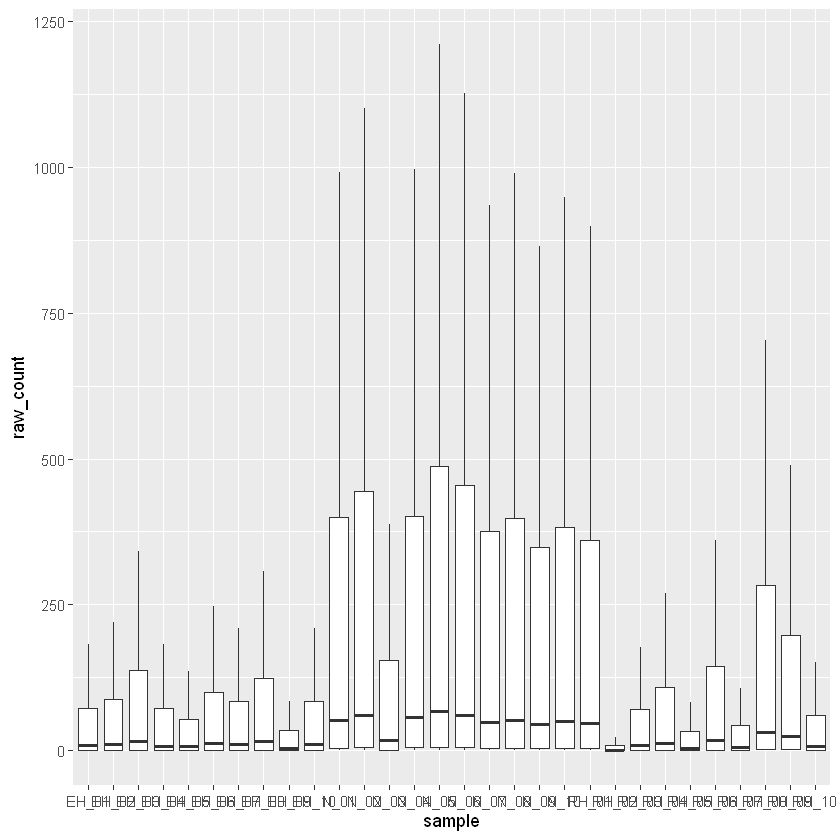

In [19]:
# Plotting raw counts
counts(dds) %>%
  as.data.frame() %>% # convert to data frame (preserves rownames)
  rownames_to_column(var = 'feature_id') %>% # convert row names attribute to a column
  as_tibble() %>%
  pivot_longer( cols = -feature_id, 
            names_to = 'sample',
           values_to = 'raw_count') %>%
  ggplot(aes(x = sample, y = raw_count)) +
  geom_boxplot(outliers = F) 

The raw boxplot above shows that there is higher counts in the normal group with a wide range compared to the other two conditions. Normalization will help even the playing field in case there was a difference in library prep or the result we are seeing is biological.

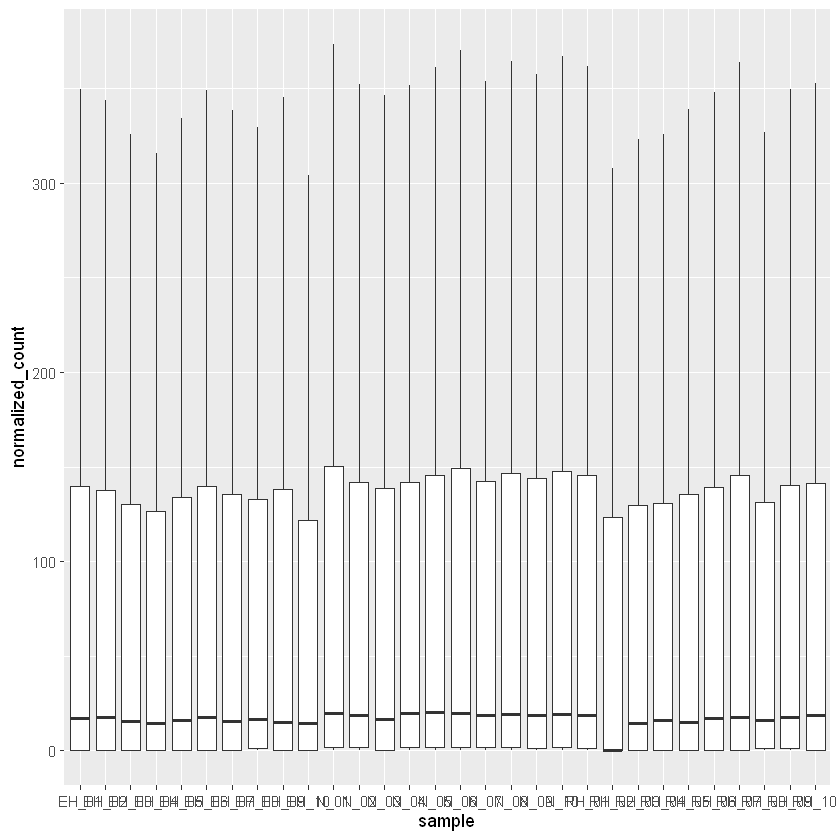

In [20]:
# Plotting normal counts
normalizedcounts.long.tbl_df %>%
  ggplot(aes(x = sample, y = normalized_count)) +
  geom_boxplot(outliers = F) 

Warning message:
"Removed 4330 rows containing missing values or values outside the scale range
(`geom_point()`)."


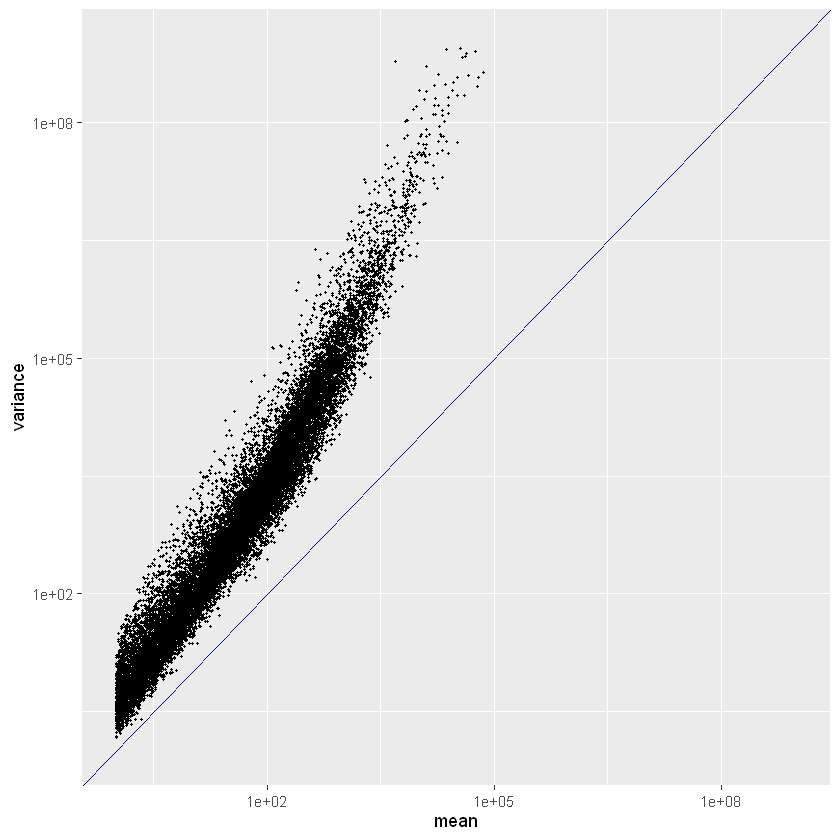

In [21]:
normalizedcounts.long.tbl_df %>%
  filter(is.finite(normalized_count)) %>%
  group_by(feature_id) %>% # "group the data by gene", all subsequent operations are performed separately on each group.
  summarise(mean = mean(normalized_count),
            variance = var(normalized_count)) %>% # for each gene, calculate mean and variance and save in new colums "mean" and "variance" in a "collapsed" tibble with one summary row per gene.
  ggplot(aes(x = mean,y = variance)) +
    geom_point(size = .6) +
    scale_y_log10(limits = c(1,1e9)) +
    scale_x_log10(limits = c(1,1e9)) +
    geom_abline(intercept = 0, slope = 1, color="dark blue")

High rate of dispersion as expected in read count data

In [22]:
#converting to log to conduct PCA
rld <- rlog(dds)

rlog() may take a few minutes with 30 or more samples,
vst() is a much faster transformation



using ntop=500 top features by variance



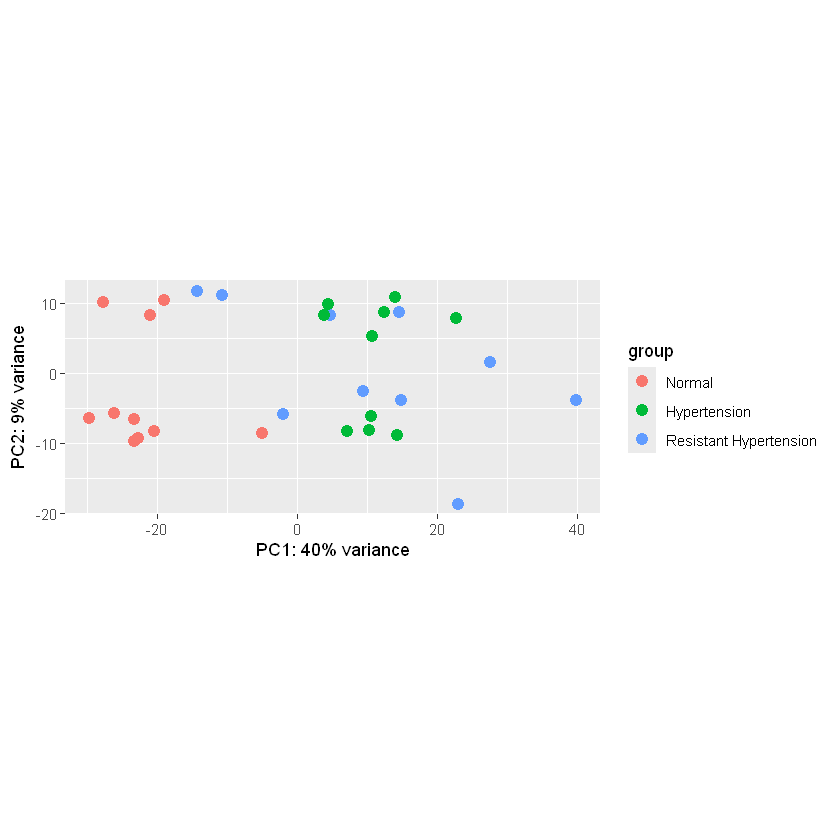

In [23]:
plotPCA(rld)

Observing the PCA plot above, the first principal component contributes to the most variation depicted by the x-axis. Furthermore the normal and hypertensive group are nicely seperated by the x-axis which shows a difference in counts for this particular gene. Interestingly, the resistant hypertensive group shows a large spread in the x axis, but still somewhat distinct from the normal group.

### Custom PCA plotting

Since the DESeq2 PCA plot is quite limiting in seeing the loadings of the Principal Components, going to do a manual PCA to use further downstream in the analysis and potentially opt for machine learning to see if there is a diagnostic value.

In [24]:
mat <- assay(rld)

In [25]:
pca <- prcomp(t(mat), scale. = FALSE) #data already normalized

In [26]:
summary(pca)

Importance of components:
                           PC1      PC2      PC3      PC4      PC5      PC6
Standard deviation     44.6348 17.15390 16.00749 15.52537 14.72436 14.71053
Proportion of Variance  0.3503  0.05175  0.04506  0.04239  0.03813  0.03805
Cumulative Proportion   0.3503  0.40209  0.44715  0.48954  0.52766  0.56572
                            PC7      PC8      PC9     PC10     PC11     PC12
Standard deviation     14.04929 13.66255 13.33895 12.81329 12.30607 12.14325
Proportion of Variance  0.03471  0.03283  0.03129  0.02887  0.02663  0.02593
Cumulative Proportion   0.60043  0.63325  0.66454  0.69341  0.72004  0.74597
                           PC13    PC14     PC15     PC16     PC17     PC18
Standard deviation     11.90195 11.5118 11.39843 11.07559 10.62559 10.30301
Proportion of Variance  0.02491  0.0233  0.02285  0.02157  0.01985  0.01867
Cumulative Proportion   0.77088  0.7942  0.81704  0.83861  0.85846  0.87713
                         PC19    PC20    PC21    PC22    P

Atleast for PC1 and PC2 the proportion of variance is similar. The slight differences could be the fact that DESeq2 only takes into account the top 500 variable genes.

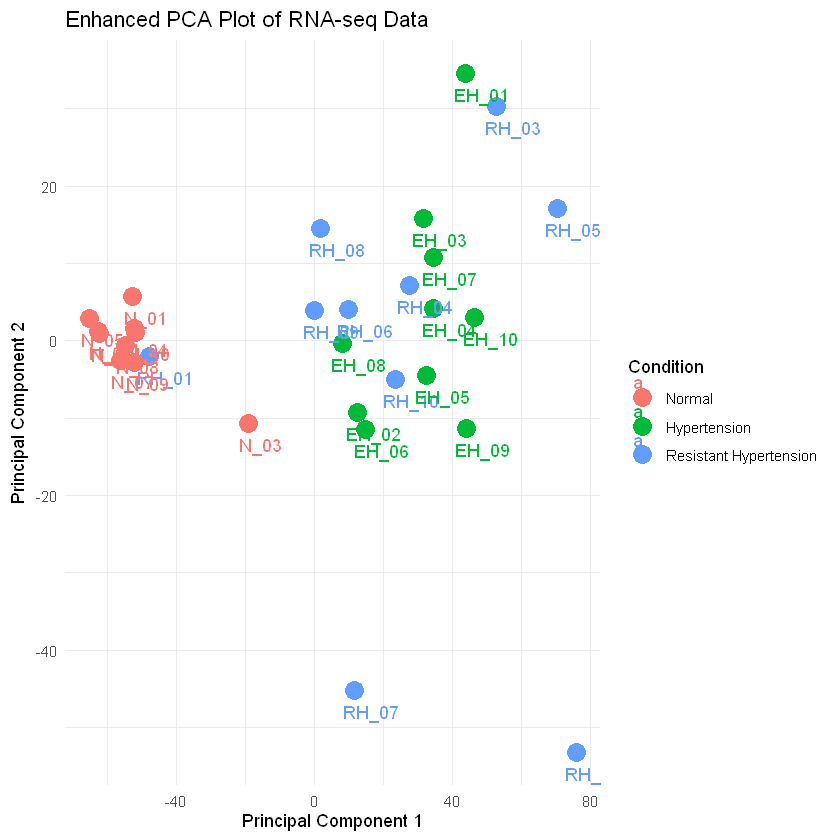

In [27]:
# Create data frame for ggplot
pcaResults <- as.data.frame(pca$x)
pcaResults$Sample <- rownames(pcaResults)
pcaResults$Condition <- metadata.df$condition

# Plotting the PCA with enhanced contrast
ggplot(pcaResults, aes(x = PC1, y = PC2, color = Condition, label = Sample)) +
  geom_point(size = 5) +
  geom_text(vjust = 2, hjust = 0.2) +
  labs(title = "Enhanced PCA Plot of RNA-seq Data", x = "Principal Component 1", y = "Principal Component 2") +
  theme_minimal()

With the custom plot we see that there is an outlier for the resistant hypertension group with the normal. The normal is nicely distinct from the diseased groups. The two hypertensive groups are very similar to eachother with the resistant hypertension group showing a large variance in the PC2.

In [28]:
loadings <- pca$rotation
loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,⋯,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30
ENSG00000000003,-0.0024205572,-7.183512e-03,0.0053618680,-0.0021182852,0.0050173673,-0.0001085873,0.0041245708,-1.553685e-03,-5.051175e-03,-0.0001039247,⋯,5.814419e-03,-4.728378e-03,-0.0088854597,0.0018586031,0.0031972518,-0.0134412548,-0.0009368525,0.0003460800,-0.0022242862,-0.0972408238
ENSG00000000419,-0.0103463082,2.714479e-04,0.0033925004,-0.0075502737,-0.0064487185,-0.0040085423,-0.0038402810,4.251227e-03,-5.219586e-03,-0.0035741494,⋯,-1.224579e-03,-1.122659e-03,0.0004043433,0.0008139688,-0.0016182233,0.0007640377,0.0001091135,-0.0005774359,0.0007127256,0.0950890313
ENSG00000000457,-0.0075428094,-1.703133e-05,0.0025142813,0.0049332646,-0.0066650923,0.0039085108,0.0098938985,-5.305112e-03,-7.458362e-03,-0.0048317697,⋯,-9.145433e-04,1.517958e-03,-0.0019623233,0.0029200193,0.0048322025,0.0055031204,0.0010888172,0.0056641453,-0.0042120469,-0.0157272499
ENSG00000000460,-0.0064975338,-7.163020e-03,0.0009979545,0.0080748472,0.0024003581,-0.0003687981,0.0026474770,3.989898e-03,-4.277745e-03,0.0032882406,⋯,5.586961e-04,-5.137354e-03,0.0028862050,-0.0042335956,0.0097934019,0.0039305499,-0.0118241061,0.0012397803,-0.0221285097,0.0001076294
ENSG00000000938,0.0045346556,1.634464e-03,-0.0085379850,-0.0021832544,0.0038970216,0.0004603772,-0.0011637648,2.763493e-03,1.820921e-03,0.0024597642,⋯,-3.725540e-03,2.660408e-04,-0.0030378095,0.0042759196,-0.0080101997,-0.0004364091,-0.0049815066,-0.0054183103,-0.0020414993,0.0171177522
ENSG00000000971,-0.0113208450,-1.229457e-03,-0.0010561935,-0.0081517729,0.0042025318,0.0079305544,0.0032307615,-2.699588e-03,1.375597e-02,-0.0057378209,⋯,1.466834e-03,-2.710203e-03,-0.0050405741,-0.0005904658,-0.0075506409,0.0011631495,0.0045214455,0.0163904400,-0.0048850818,-0.0084139892
ENSG00000001036,-0.0015992997,-2.941293e-04,-0.0093556649,0.0012948703,0.0050134736,-0.0014431598,-0.0002050743,3.342228e-03,8.815961e-04,-0.0010972717,⋯,-5.547568e-03,8.190578e-03,0.0076839434,-0.0055085134,-0.0083596150,0.0080403768,-0.0009703587,-0.0066994667,0.0079604491,-0.0159897805
ENSG00000001084,-0.0007208323,-8.873766e-03,0.0026329034,0.0021710419,-0.0030681025,-0.0223237705,-0.0108201232,2.250595e-03,-1.166174e-03,-0.0008272196,⋯,7.622724e-03,5.397402e-03,0.0002146992,-0.0020490129,-0.0010211557,-0.0075208099,0.0025064929,-0.0002660072,-0.0005965225,0.0008159372
ENSG00000001167,-0.0107662347,4.657627e-03,-0.0044788176,0.0064584516,-0.0098796649,-0.0017663454,-0.0074743420,6.183836e-03,-5.232267e-03,0.0107400482,⋯,-9.717123e-04,-5.960336e-05,0.0028018292,0.0087163422,0.0003990964,-0.0011247239,0.0034110452,0.0006173324,-0.0032809692,0.0101178909
ENSG00000001460,-0.0028200644,5.190221e-03,-0.0026301741,0.0034942214,0.0058525148,-0.0042317664,-0.0025651858,-4.243461e-03,1.435729e-03,-0.0025254838,⋯,9.095739e-03,3.180679e-03,0.0023699843,-0.0106498033,0.0032138211,-0.0011622282,-0.0054467484,0.0005683260,-0.0035194175,0.0190148844


In [29]:
top_genes_PC1 <- sort(abs(loadings[, 1]), decreasing = TRUE)
top_genes_PC2 <- sort(abs(loadings[, 2]), decreasing = TRUE)

head(top_genes_PC1, 10)

ENSG00000162366 ENSG00000178297 ENSG00000013306 ENSG00000206177 ENSG00000086506 
     0.03466714      0.03398514      0.03286385      0.03266321      0.03163592 
ENSG00000244734 ENSG00000143774 ENSG00000187017 ENSG00000269711 ENSG00000104892 
     0.03160186      0.03156787      0.03135269      0.03106446      0.03104326

In [30]:
pc1 <- as.list(top_genes_PC1)
pc2 <- as.list(top_genes_PC2)

In [31]:
top_gene_names_PC1 <- pc1[1:10]
top_gene_names_PC2 <- pc2[1:10]

Ordering the top 10 principal components for later analysis and potential machine learning.

### Diffrerential Gene Analysis

In [32]:
#performing differential analysis
dds <- DESeq(dds)

using pre-existing normalization factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

final dispersion estimates

fitting model and testing

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

-- replacing outliers and refitting for 166 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

  Note: levels o

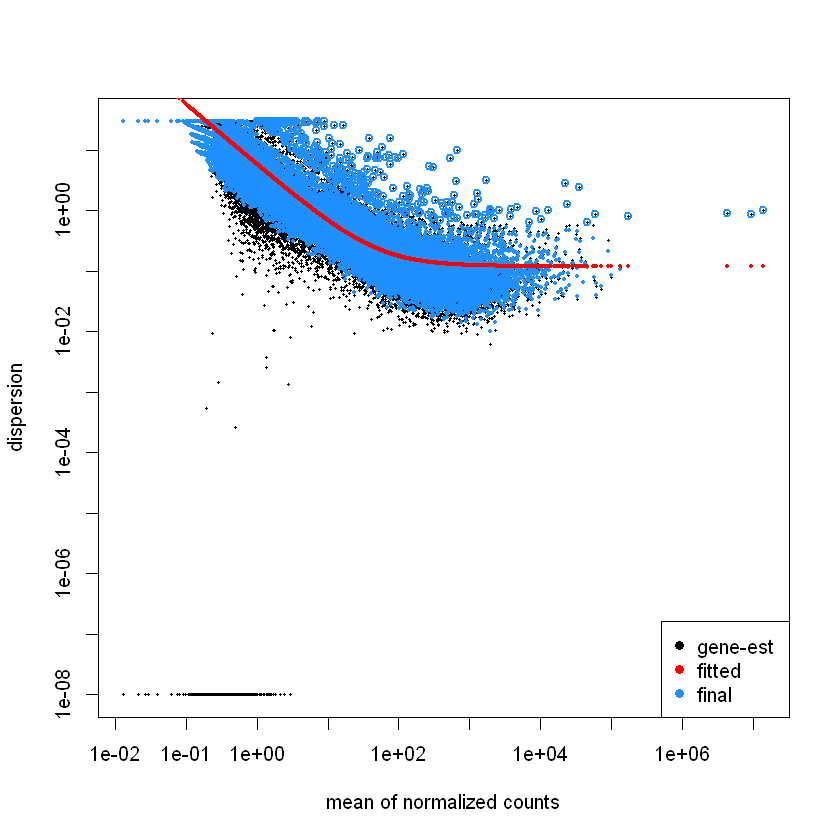

In [33]:
plotDispEsts(dds)

Quite large dispersion in lower count genes, however levels off as the count increases. This is to be expected.

#### Normal and Hypertensive group comparison

In [34]:
res_N_EH <- results(dds, contrast = c('condition','Hypertension','Normal'),alpha = 0.05)

# View
res_N_EH

log2 fold change (MLE): condition Hypertension vs Normal 
Wald test p-value: condition Hypertension vs Normal 
DataFrame with 22749 rows and 6 columns
                  baseMean log2FoldChange     lfcSE      stat      pvalue
                 <numeric>      <numeric> <numeric> <numeric>   <numeric>
ENSG00000000003    1.89727      -2.818777  1.017275  -2.77091 5.59000e-03
ENSG00000000419   87.83449      -1.331771  0.196080  -6.79197 1.10614e-11
ENSG00000000457   77.26543      -1.020823  0.204951  -4.98082 6.33166e-07
ENSG00000000460   18.68055      -0.875476  0.372502  -2.35026 1.87605e-02
ENSG00000000938 4575.90143       0.625316  0.131289   4.76289 1.90836e-06
...                    ...            ...       ...       ...         ...
ENSG00000293550  35.118450      -0.541717  0.337002 -1.607460    0.107953
ENSG00000293552   0.657624      -2.015082  2.008324 -1.003365    0.315685
ENSG00000293553   0.652694       4.191508  2.299924  1.822455    0.068386
ENSG00000293555   0.260450       1.

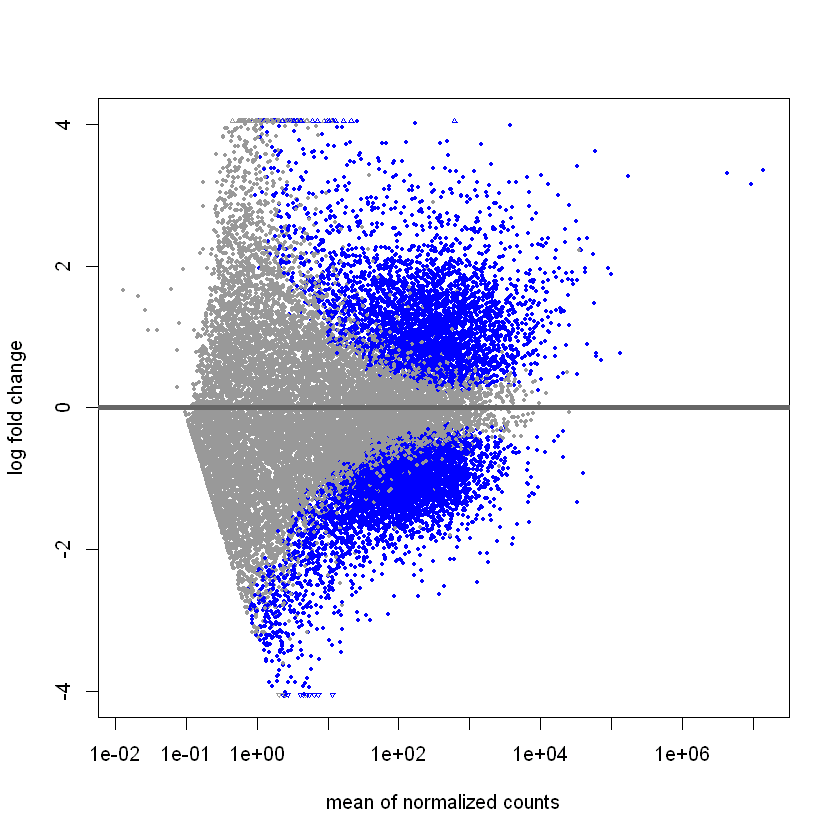

In [35]:
plotMA(res_N_EH)

In [36]:
BiocManager::install("apeglm")

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.20 (BiocManager 1.30.25), R 4.4.2 (2024-10-31 ucrt)

Warning message:
"package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'apeglm'"
Old packages: 'BH', 'BiocParallel', 'biomaRt', 'Biostrings', 'bit', 'bit64',
  'broom', 'bslib', 'caret', 'chron', 'class', 'cli', 'clock', 'commonmark',
  'cpp11', 'curl', 'data.table', 'diffobj', 'downloader', 'evaluate', 'fs',
  'future', 'GenomeInfoDb', 'gert', 'ggplot2', 'globals', 'gower', 'hardhat',
  'httpuv', 'httr2', 'IRanges', 'jsonlite', 'KernSmooth', 'knitr', 'later',
  'lattice', 'lava', 'locfit', 'lubridate', 'MASS', 'Matrix', 'MatrixGenerics',
  'matrixStats', 'mgcv', 'mime', 'miniUI', 'nlme', 'nnet', 'openssl',
  'parallelly', 'pbdZMQ', 'pillar', 'pkgbuild', 'pkgdown'

In [37]:
BiocManager::install("ashr")

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.20 (BiocManager 1.30.25), R 4.4.2 (2024-10-31 ucrt)

Warning message:
"package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'ashr'"
Old packages: 'BH', 'BiocParallel', 'biomaRt', 'Biostrings', 'bit', 'bit64',
  'broom', 'bslib', 'caret', 'chron', 'class', 'cli', 'clock', 'commonmark',
  'cpp11', 'curl', 'data.table', 'diffobj', 'downloader', 'evaluate', 'fs',
  'future', 'GenomeInfoDb', 'gert', 'ggplot2', 'globals', 'gower', 'hardhat',
  'httpuv', 'httr2', 'IRanges', 'jsonlite', 'KernSmooth', 'knitr', 'later',
  'lattice', 'lava', 'locfit', 'lubridate', 'MASS', 'Matrix', 'MatrixGenerics',
  'matrixStats', 'mgcv', 'mime', 'miniUI', 'nlme', 'nnet', 'openssl',
  'parallelly', 'pbdZMQ', 'pillar', 'pkgbuild', 'pkgdown', 

In [38]:
resultsNames(dds)

res.lfcShrink <- lfcShrink(dds, 
                           res = res_N_EH,
                           coef = 'condition_Hypertension_vs_Normal',
                           type = 'ashr')
# View
res.lfcShrink

[1] "Intercept"                                 
[2] "condition_Hypertension_vs_Normal"          
[3] "condition_Resistant.Hypertension_vs_Normal"

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041



log2 fold change (MMSE): condition Hypertension vs Normal 
Wald test p-value: condition Hypertension vs Normal 
DataFrame with 22749 rows and 5 columns
                  baseMean log2FoldChange     lfcSE      pvalue        padj
                 <numeric>      <numeric> <numeric>   <numeric>   <numeric>
ENSG00000000003    1.89727      -1.288908  0.700374 5.59000e-03 1.50757e-02
ENSG00000000419   87.83449      -1.274199  0.191920 1.10614e-11 2.68975e-10
ENSG00000000457   77.26543      -0.972544  0.200114 6.33166e-07 4.59679e-06
ENSG00000000460   18.68055      -0.752046  0.345461 1.87605e-02 4.31811e-02
ENSG00000000938 4575.90143       0.612776  0.129972 1.90836e-06 1.23516e-05
...                    ...            ...       ...         ...         ...
ENSG00000293550  35.118450      -0.477400  0.316423    0.107953    0.186073
ENSG00000293552   0.657624      -0.354422  0.843980    0.315685          NA
ENSG00000293553   0.652694       0.590163  0.869202    0.068386          NA
ENSG00000293

In [39]:
summary(res.lfcShrink)
sum(is.na(res.lfcShrink$log2FoldChange))


out of 22737 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 3773, 17%
LFC < 0 (down)     : 4746, 21%
outliers [1]       : 0, 0%
low counts [2]     : 3539, 16%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



[1] 0

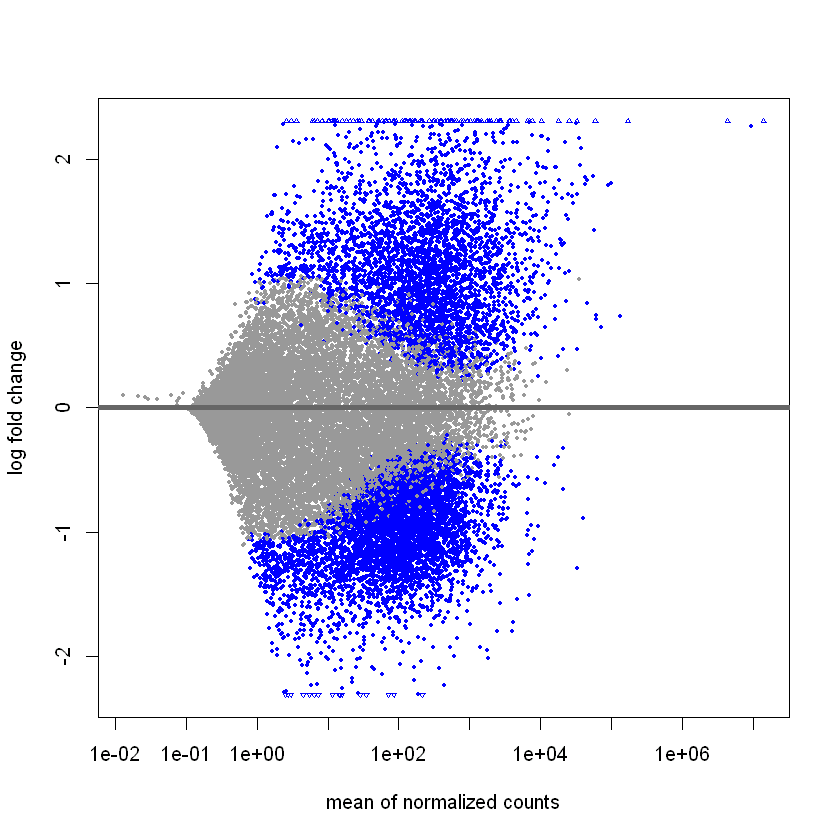

In [40]:
plotMA(res.lfcShrink)

Using lfc shrink in order to get more accurate logfold2 change

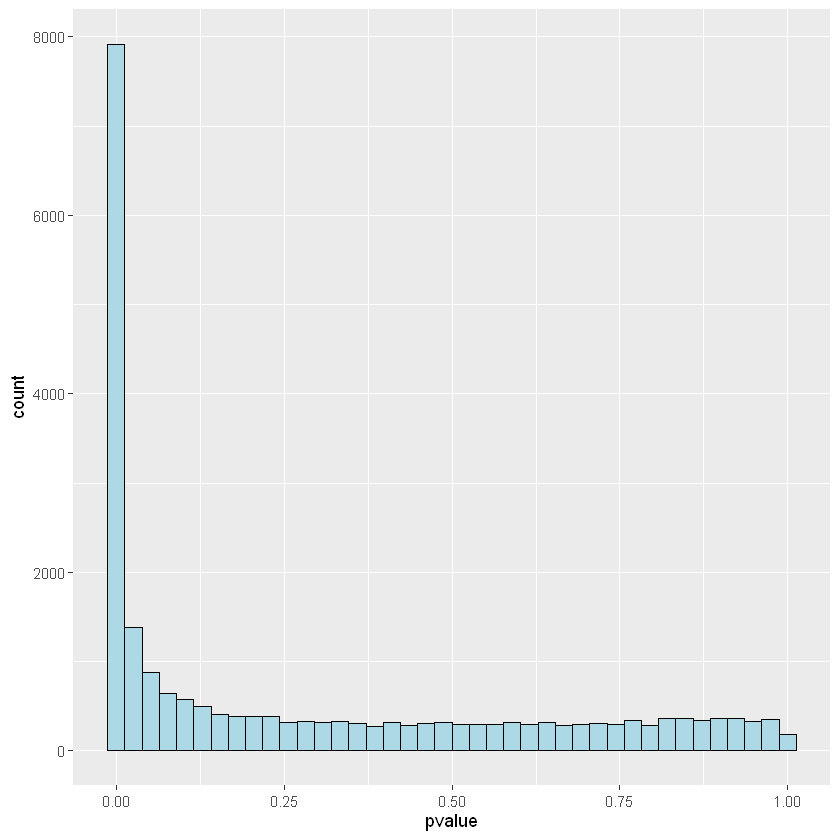

In [41]:
res.lfcShrink %>%
  as_tibble() %>% # coerce to tibble
  ggplot(aes(pvalue)) + 
  geom_histogram(fill="light blue",color='black',bins = 40)

In lower p-value range there is some differential expression going on between normal and hypertensive

In [42]:
res.lfcShrink.tbl_df <- res.lfcShrink %>%
  as.data.frame() %>%
  rownames_to_column(var = "feature_id") %>%
  as_tibble()

res.lfcShrink.tbl_df %>% 
  arrange(padj) # sort tibble in ascending order on adjusted p-value (FDR)

feature_id,baseMean,log2FoldChange,lfcSE,pvalue,padj
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000133317,124.1244,2.521671,0.2025303,1.035015e-37,1.988265e-33
ENSG00000092020,103.9169,-2.059018,0.1796573,1.152946e-31,1.107405e-27
ENSG00000110852,215.6333,-2.325658,0.2094339,2.281778e-30,1.461099e-26
ENSG00000108828,421.3082,1.822094,0.1635725,9.179701e-30,4.408552e-26
ENSG00000067225,4882.3588,1.436431,0.1293142,3.145952e-29,1.208675e-25
ENSG00000101439,7686.4031,2.187182,0.2020893,9.147719e-29,2.692844e-25
ENSG00000204619,649.9800,1.183894,0.1071916,9.812548e-29,2.692844e-25
ENSG00000117984,10217.1380,2.179612,0.2078498,3.461684e-27,8.312369e-24
ENSG00000198816,166.7187,2.440578,0.2357146,4.243005e-27,9.056459e-24


Warning message in geom_point(colr = "gray"):
"Ignoring unknown parameters: `colr`"
Warning message:
"Removed 3539 rows containing missing values or values outside the scale range
(`geom_point()`)."


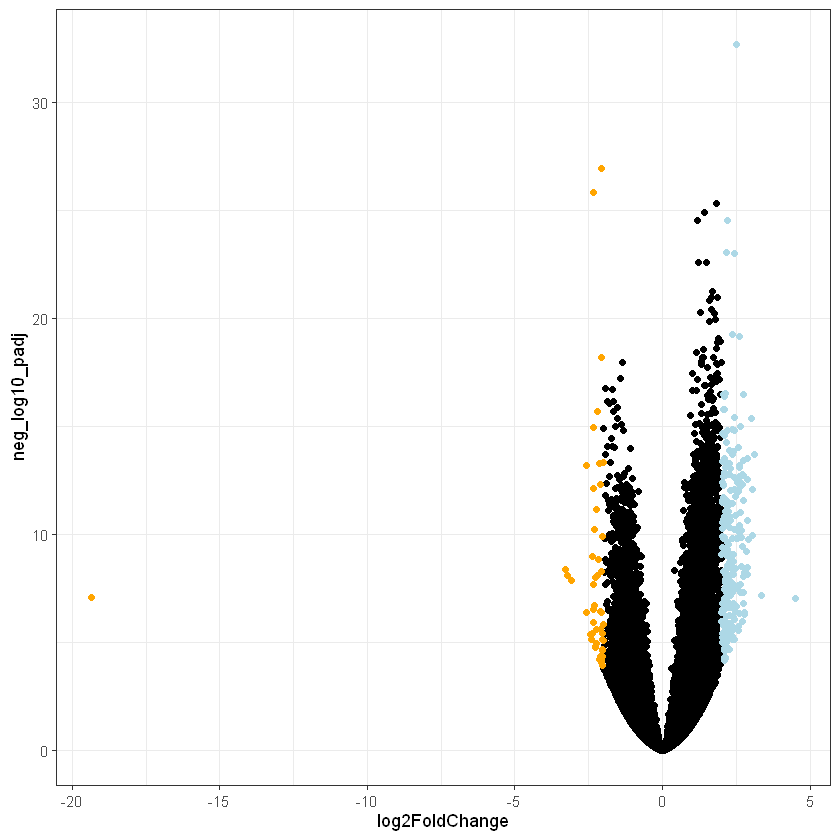

In [43]:
res.lfcShrink.tbl_df %>% # pipe the data.frame (tibble) to mutate to add a column named "neg_log10_padj" with negative log10 adjusted p-values
  mutate(neg_log10_padj = -1*log10(padj)) %>% # pipe the modified data.frame (tibble) to first (data) argument of ggplot
  ggplot(aes(x = log2FoldChange, y = neg_log10_padj)) + # define which columns (variables) to plot on x and y axes with aes()
  geom_point(colr = 'gray') + # add gray points
  geom_point( data = ~.x %>% filter(log2FoldChange < -2 & neg_log10_padj > 2), color = 'orange') + # add a second layer of orange points on subset of data
  geom_point( data = ~.x %>% filter(log2FoldChange > 2 & neg_log10_padj > 2), color = 'light blue') + # add a third layer of blue points on subset of data
  theme_bw()

Significant amount of upregulated genes. Less amount of downregulation, with one gene having a very large fold chain.

In [44]:
significant_genes.v <- res.lfcShrink.tbl_df %>%
  filter(!is.na(padj)) %>% # retain only genes that don't have NA in padj column
  filter(padj < 0.05) %>% # retain only genes with FDR < 0.05
  pull(feature_id)

##### GO annotation

In [45]:
library(org.Hs.eg.db)
ensembl2gene.tbl_df <- AnnotationDbi::select(org.Hs.eg.db, keys=significant_genes.v, 
                  columns="SYMBOL", keytype="ENSEMBL") %>%
            as_tibble()
ensembl2gene.tbl_df

Loading required package: AnnotationDbi


Attaching package: 'AnnotationDbi'


The following object is masked from 'package:dplyr':

    select




'select()' returned 1:many mapping between keys and columns



ENSEMBL,SYMBOL
<chr>,<chr>
ENSG00000000003,TSPAN6
ENSG00000000419,DPM1
ENSG00000000457,SCYL3
ENSG00000000460,FIRRM
ENSG00000000938,FGR
ENSG00000000971,CFH
ENSG00000001167,NFYA
ENSG00000001497,LAS1L
ENSG00000001561,ENPP4


In [46]:
sig_genes_N_EH <- inner_join(x = res.lfcShrink.tbl_df, # DESeq2 results tibble
           y = ensembl2gene.tbl_df, # ENSEMBL to gene symbol map tibble
           by = join_by(feature_id == ENSEMBL) ) %>%
            arrange(padj) 

In [47]:
sig_genes_N_EH ## use for further downstream analysis

feature_id,baseMean,log2FoldChange,lfcSE,pvalue,padj,SYMBOL
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ENSG00000133317,124.1244,2.521671,0.2025303,1.035015e-37,1.988265e-33,LGALS12
ENSG00000092020,103.9169,-2.059018,0.1796573,1.152946e-31,1.107405e-27,PPP2R3C
ENSG00000110852,215.6333,-2.325658,0.2094339,2.281778e-30,1.461099e-26,CLEC2B
ENSG00000108828,421.3082,1.822094,0.1635725,9.179701e-30,4.408552e-26,VAT1
ENSG00000067225,4882.3588,1.436431,0.1293142,3.145952e-29,1.208675e-25,PKM
ENSG00000101439,7686.4031,2.187182,0.2020893,9.147719e-29,2.692844e-25,CST3
ENSG00000204619,649.9800,1.183894,0.1071916,9.812548e-29,2.692844e-25,PPP1R11
ENSG00000117984,10217.1380,2.179612,0.2078498,3.461684e-27,8.312369e-24,CTSD
ENSG00000198816,166.7187,2.440578,0.2357146,4.243005e-27,9.056459e-24,ZNF358


In [48]:
write.csv(sig_genes_N_EH, "sig_genes_normal_vs_hypertensive.csv", row.names = FALSE)


In [49]:
tribble(~`DEG class`,~`Genes annotated with GO of interest`,~`Genes not annotated with GO of interest`,~Total,
        'DEG','n11','n12','n1+',
        'not DEG','n21','n22','n2+',
        'Total','n+1','n+2','n')

DEG class,Genes annotated with GO of interest,Genes not annotated with GO of interest,Total
<chr>,<chr>,<chr>,<chr>
DEG,n11,n12,n1+
not DEG,n21,n22,n2+
Total,n+1,n+2,n


In [50]:
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("clusterProfiler")

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.20 (BiocManager 1.30.25), R 4.4.2 (2024-10-31 ucrt)

Warning message:
"package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'clusterProfiler'"
Old packages: 'BH', 'BiocParallel', 'biomaRt', 'Biostrings', 'bit', 'bit64',
  'broom', 'bslib', 'caret', 'chron', 'class', 'cli', 'clock', 'commonmark',
  'cpp11', 'curl', 'data.table', 'diffobj', 'downloader', 'evaluate', 'fs',
  'future', 'GenomeInfoDb', 'gert', 'ggplot2', 'globals', 'gower', 'hardhat',
  'httpuv', 'httr2', 'IRanges', 'jsonlite', 'KernSmooth', 'knitr', 'later',
  'lattice', 'lava', 'locfit', 'lubridate', 'MASS', 'Matrix', 'MatrixGenerics',
  'matrixStats', 'mgcv', 'mime', 'miniUI', 'nlme', 'nnet', 'openssl',
  'parallelly', 'pbdZMQ', 'pillar', 'pkgbuild', 

In [51]:
universe_genes.v <- res.lfcShrink.tbl_df %>%
  filter(!is.na(padj)) %>% # here we preserve any gene that does not have missing data after independent filtering in the results object
  pull(feature_id)

length(universe_genes.v)

[1] 19210

In [52]:
# This will output a data.frame-like object of class enrichResult
library(clusterProfiler)
bp.enrichResult <- enrichGO(gene = significant_genes.v, # specifify the significant set of genes
         OrgDb = org.Hs.eg.db,
         keyType = "ENSEMBL",
         ont = "BP", # select Biological Process ontology. Molecular Function (MF) and Cellular Compartment (CC) may also be interesting
         pAdjustMethod = "BH",
         universe = universe_genes.v) # specify the background set of genes



clusterProfiler v4.14.6 Learn more at https://yulab-smu.top/contribution-knowledge-mining/

Please cite:

S Xu, E Hu, Y Cai, Z Xie, X Luo, L Zhan, W Tang, Q Wang, B Liu, R Wang,
W Xie, T Wu, L Xie, G Yu. Using clusterProfiler to characterize
multiomics data. Nature Protocols. 2024, 19(11):3292-3320


Attaching package: 'clusterProfiler'


The following object is masked from 'package:AnnotationDbi':

    select


The following object is masked from 'package:IRanges':

    slice


The following object is masked from 'package:S4Vectors':

    rename


The following object is masked from 'package:purrr':

    simplify


The following object is masked from 'package:stats':

    filter




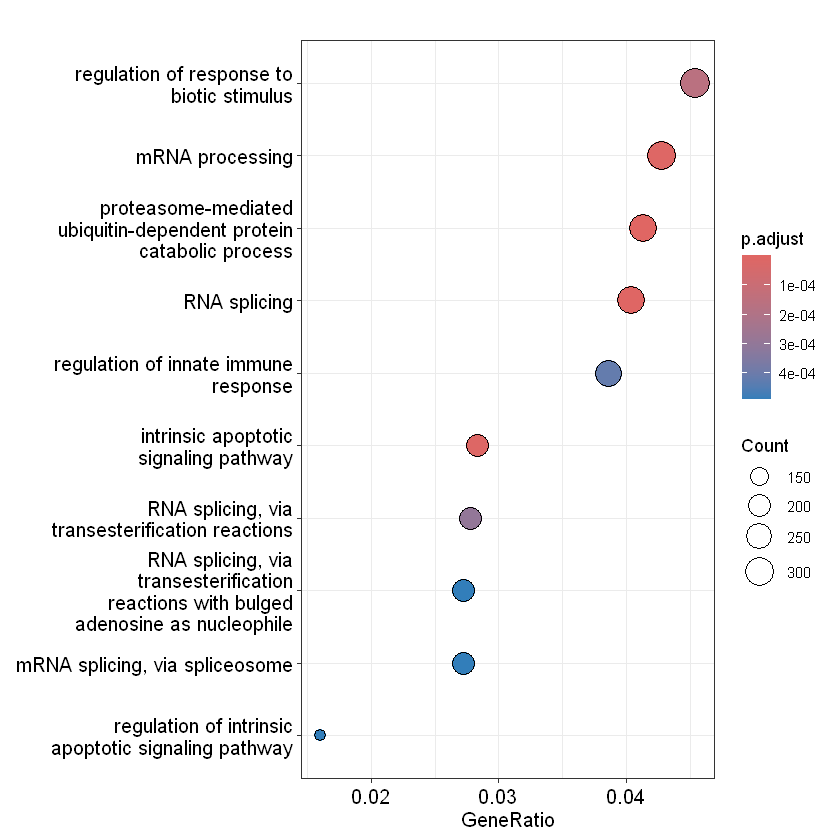

In [53]:
dotplot(bp.enrichResult, showCategory=10)

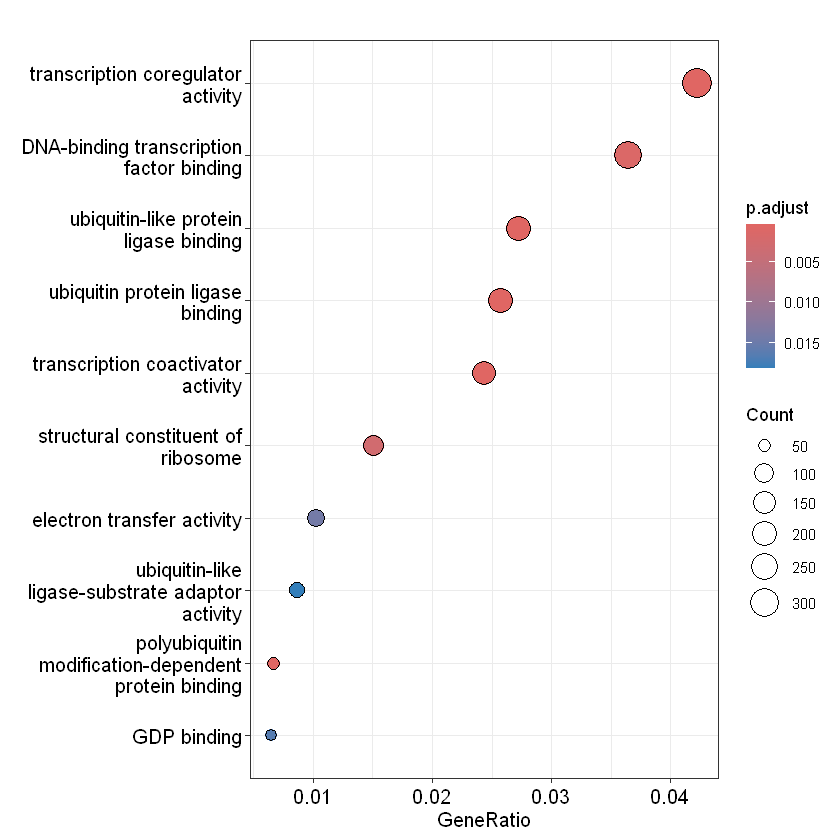

In [54]:
mf.enrichResult <- enrichGO(gene = significant_genes.v, # specifify the significant set of genes
         OrgDb = org.Hs.eg.db,
         keyType = "ENSEMBL",
         ont = "MF", # select Biological Process ontology. Molecular Function (MF) and Cellular Compartment (CC) may also be interesting
         pAdjustMethod = "BH",
         universe = universe_genes.v) # specify the background set of genes
dotplot(mf.enrichResult, showCategory=10)

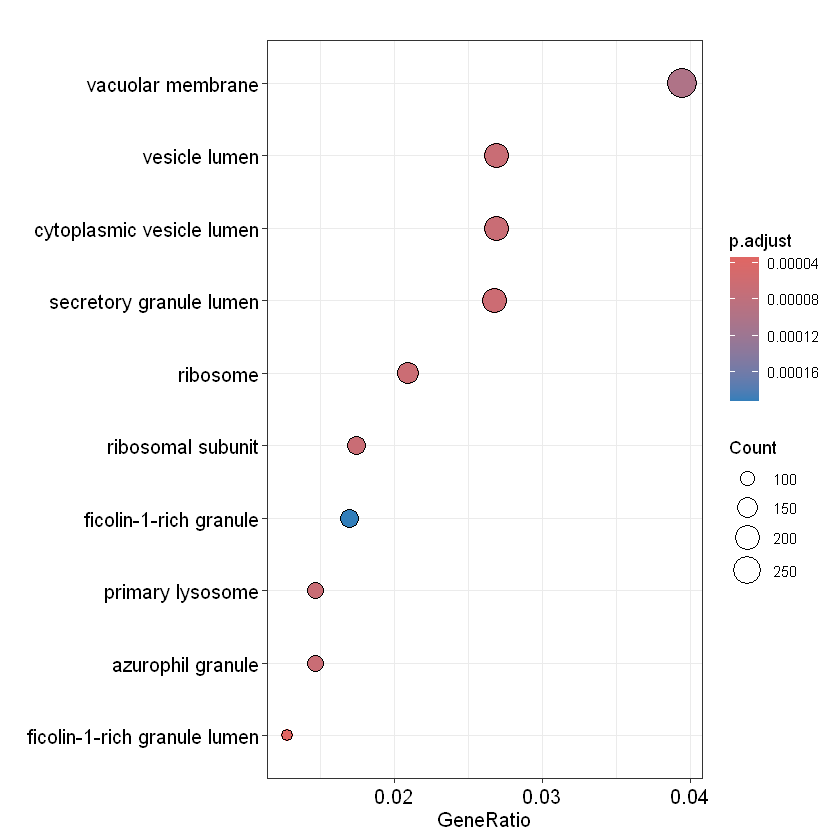

In [55]:
cc.enrichResult <- enrichGO(gene = significant_genes.v, # specifify the significant set of genes
         OrgDb = org.Hs.eg.db,
         keyType = "ENSEMBL",
         ont = "CC", # select Biological Process ontology. Molecular Function (MF) and Cellular Compartment (CC) may also be interesting
         pAdjustMethod = "BH",
         universe = universe_genes.v) # specify the background set of genes
dotplot(cc.enrichResult, showCategory=10)

In [56]:
library("GOstats")
library("GO.db")
library("Category")
library("org.Hs.eg.db")

Loading required package: Category

Loading required package: Matrix


Attaching package: 'Matrix'


The following object is masked from 'package:S4Vectors':

    expand


The following objects are masked from 'package:tidyr':

    expand, pack, unpack


Loading required package: graph


Attaching package: 'graph'


The following object is masked from 'package:stringr':

    boundary



Attaching package: 'GOstats'


The following object is masked from 'package:AnnotationDbi':

    makeGOGraph




#### Normal and Resistant hypertensive

In [57]:
res_N_RH <- results(dds, contrast = c('condition','Resistant Hypertension','Normal'),alpha = 0.05)

# View
res_N_RH

log2 fold change (MLE): condition Resistant Hypertension vs Normal 
Wald test p-value: condition Resistant.Hypertension vs Normal 
DataFrame with 22749 rows and 6 columns
                  baseMean log2FoldChange     lfcSE      stat      pvalue
                 <numeric>      <numeric> <numeric> <numeric>   <numeric>
ENSG00000000003    1.89727      -1.063566  0.915261  -1.16204 2.45221e-01
ENSG00000000419   87.83449      -0.981962  0.195040  -5.03468 4.78651e-07
ENSG00000000457   77.26543      -0.655266  0.205178  -3.19365 1.40488e-03
ENSG00000000460   18.68055      -1.478122  0.380353  -3.88619 1.01831e-04
ENSG00000000938 4575.90143       0.398456  0.131455   3.03113 2.43644e-03
...                    ...            ...       ...       ...         ...
ENSG00000293550  35.118450      -1.422321  0.351551 -4.045843 5.21351e-05
ENSG00000293552   0.657624      -1.066718  1.983513 -0.537792 5.90720e-01
ENSG00000293553   0.652694       1.521546  2.342956  0.649413 5.16071e-01
ENSG00000293555

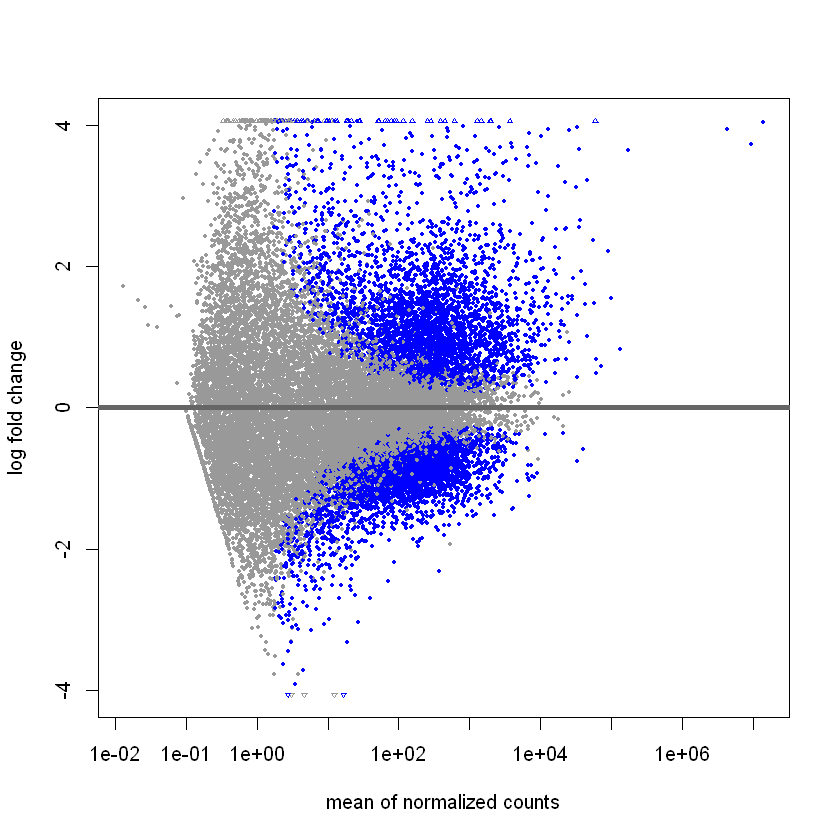

In [58]:
plotMA(res_N_RH)

In [59]:
resultsNames(dds) # Here we can see the coefficients including 'condition_tumor_vs_normal'

# note: by providing res as an argument we ensure that alpha = 0.05 is also the basis for p-values reported by lfcShrink.
res.lfcShrink <- lfcShrink(dds, 
                           res = res_N_RH,
                           coef = 'condition_Resistant.Hypertension_vs_Normal',
                           type = 'ashr')
# View
res.lfcShrink

[1] "Intercept"                                 
[2] "condition_Hypertension_vs_Normal"          
[3] "condition_Resistant.Hypertension_vs_Normal"

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041



log2 fold change (MMSE): condition Resistant Hypertension vs Normal 
Wald test p-value: condition Resistant.Hypertension vs Normal 
DataFrame with 22749 rows and 5 columns
                  baseMean log2FoldChange     lfcSE      pvalue        padj
                 <numeric>      <numeric> <numeric>   <numeric>   <numeric>
ENSG00000000003    1.89727      -0.438625  0.595808 2.45221e-01 3.55943e-01
ENSG00000000419   87.83449      -0.920113  0.189328 4.78651e-07 5.11624e-06
ENSG00000000457   77.26543      -0.608996  0.198006 1.40488e-03 5.25662e-03
ENSG00000000460   18.68055      -1.193001  0.351087 1.01831e-04 5.51155e-04
ENSG00000000938 4575.90143       0.386282  0.129450 2.43644e-03 8.33015e-03
...                    ...            ...       ...         ...         ...
ENSG00000293550  35.118450     -1.1793448  0.327217 5.21351e-05 0.000308815
ENSG00000293552   0.657624     -0.1476176  0.741775 5.90720e-01          NA
ENSG00000293553   0.652694      0.1602390  0.766111 5.16071e-01     

In [60]:
summary(res.lfcShrink)
sum(is.na(res.lfcShrink$log2FoldChange))


out of 22737 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 3522, 15%
LFC < 0 (down)     : 3623, 16%
outliers [1]       : 0, 0%
low counts [2]     : 5743, 25%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



[1] 0

Compared to the Hypertensive groups there is very similar percentage of upregulated and down regulated genes . The MA plot is very similar which shows a very similar genetic profile of the two diseased conditions.

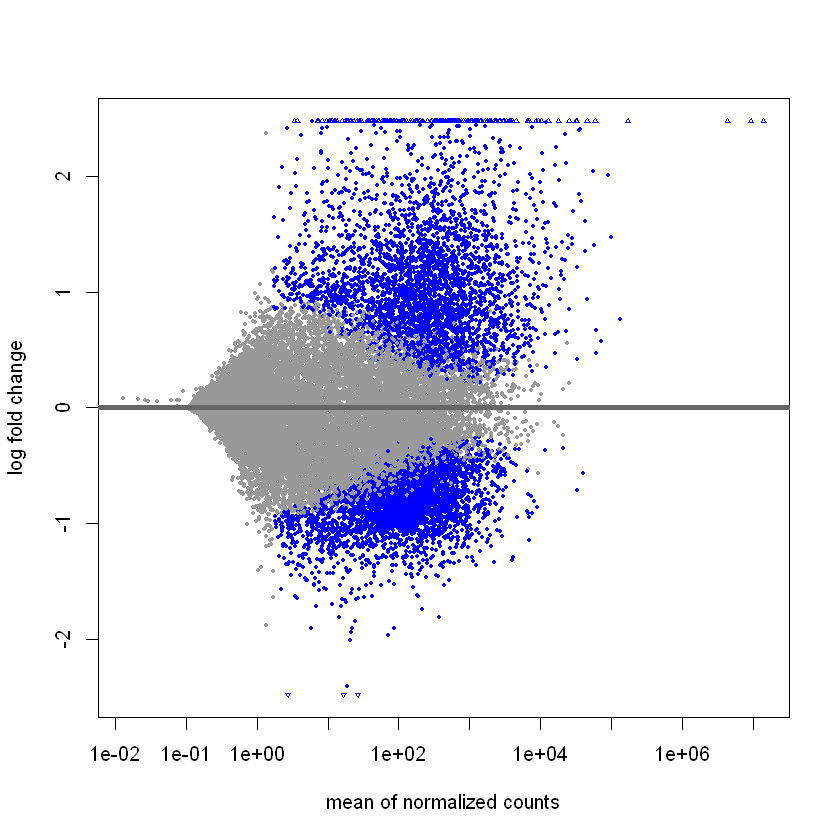

In [61]:
plotMA(res.lfcShrink)

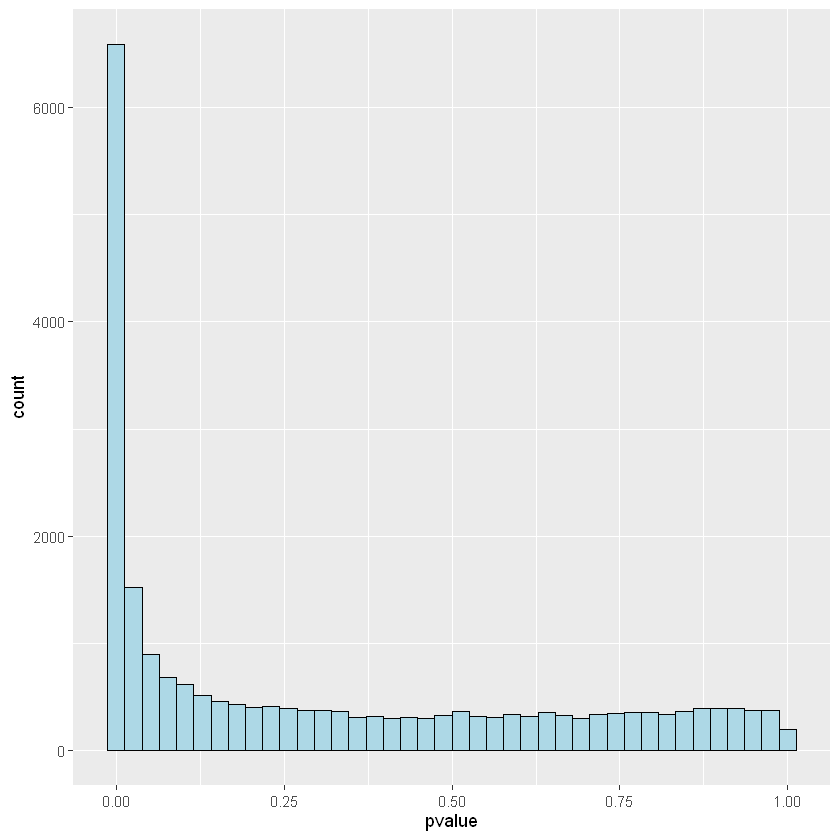

In [62]:
res.lfcShrink %>%
  as_tibble() %>% # coerce to tibble
  ggplot(aes(pvalue)) + 
  geom_histogram(fill="light blue",color='black',bins = 40)

In [63]:
res.lfcShrink.tbl_df <- res.lfcShrink %>%
  as.data.frame() %>%
  rownames_to_column(var = "feature_id") %>%
  as_tibble()

res.lfcShrink.tbl_df %>% 
  arrange(log2FoldChange) # sort tibble in ascending order on adjusted p-value (FDR)

feature_id,baseMean,log2FoldChange,lfcSE,pvalue,padj
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000275895,2.744529,-20.111520,3.7919873,3.592153e-09,6.591308e-08
ENSG00000285238,16.635632,-5.618851,6.6669739,3.600406e-06,2.975504e-05
ENSG00000144290,26.645763,-2.512499,0.5968510,1.447827e-08,2.322807e-07
ENSG00000104290,18.771429,-2.404233,0.7923185,2.266819e-06,1.984021e-05
ENSG00000009694,20.825482,-2.010194,0.5178198,2.434321e-07,2.816194e-06
ENSG00000169429,71.713461,-1.966828,0.5010139,2.457585e-07,2.837317e-06
ENSG00000134545,21.482369,-1.938691,0.5763321,2.619295e-06,2.238379e-05
ENSG00000030419,85.357044,-1.905978,0.3534479,2.504985e-10,6.191829e-09
ENSG00000234678,5.867037,-1.901907,0.8281641,8.383260e-05,4.651410e-04


In [64]:
max(res.lfcShrink.tbl_df$log2FoldChange)


[1] 22.31412

Warning message in geom_point(colr = "gray"):
"Ignoring unknown parameters: `colr`"
Warning message:
"Removed 5743 rows containing missing values or values outside the scale range
(`geom_point()`)."


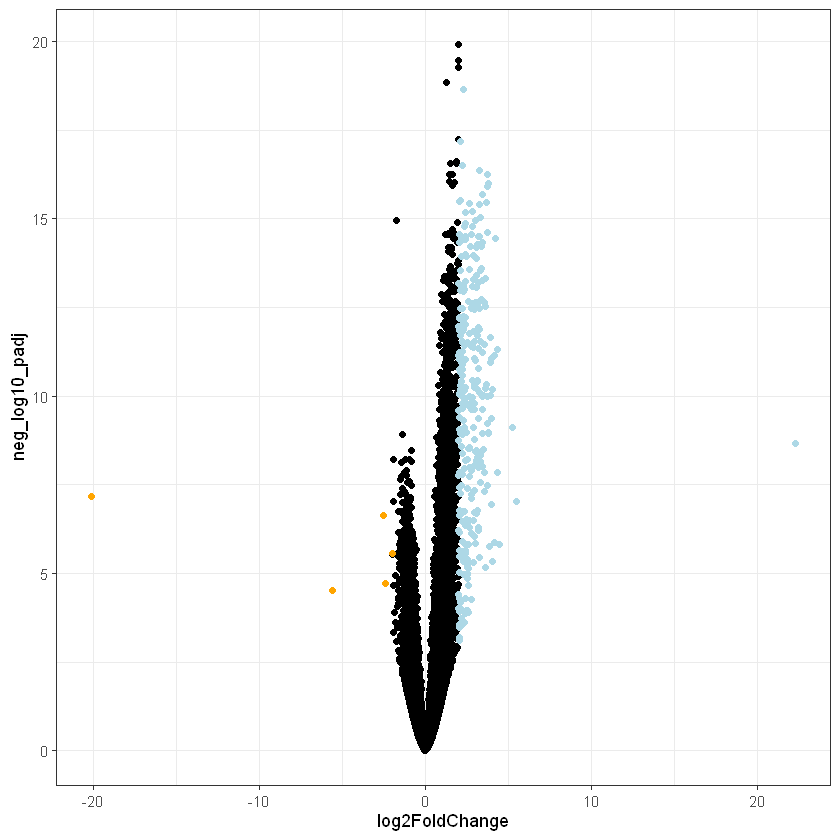

In [65]:
res.lfcShrink.tbl_df %>% # pipe the data.frame (tibble) to mutate to add a column named "neg_log10_padj" with negative log10 adjusted p-values
  mutate(neg_log10_padj = -1*log10(padj)) %>% # pipe the modified data.frame (tibble) to first (data) argument of ggplot
  ggplot(aes(x = log2FoldChange, y = neg_log10_padj)) + # define which columns (variables) to plot on x and y axes with aes()
  geom_point(colr = 'gray') + # add gray points
  geom_point( data = ~.x %>% filter(log2FoldChange < -2 & neg_log10_padj > 2), color = 'orange') + # add a second layer of orange points on subset of data
  geom_point( data = ~.x %>% filter(log2FoldChange > 2 & neg_log10_padj > 2), color = 'light blue') + # add a third layer of blue points on subset of data
  theme_bw()

Between the Normal and Resistant hypertensive there is more up regulation, whereas in the hypertensive group we see more down regulation. See two genes with an absolute value of fold chain over 20.

In [66]:
significant_genes.v <- res.lfcShrink.tbl_df %>%
  filter(!is.na(padj)) %>% # retain only genes that don't have NA in padj column
  filter(padj < 0.05) %>% # retain only genes with FDR < 0.05
  pull(feature_id)

In [67]:
ensembl2gene.tbl_df <- AnnotationDbi::select(org.Hs.eg.db, keys=significant_genes.v, 
                  columns="SYMBOL", keytype="ENSEMBL") %>%
            as_tibble()
ensembl2gene.tbl_df

'select()' returned 1:many mapping between keys and columns



ENSEMBL,SYMBOL
<chr>,<chr>
ENSG00000000419,DPM1
ENSG00000000457,SCYL3
ENSG00000000460,FIRRM
ENSG00000000938,FGR
ENSG00000001167,NFYA
ENSG00000001561,ENPP4
ENSG00000001629,ANKIB1
ENSG00000001631,KRIT1
ENSG00000002330,BAD


In [68]:
inner_join(x = res.lfcShrink.tbl_df, # DESeq2 results tibble
           y = ensembl2gene.tbl_df, # ENSEMBL to gene symbol map tibble
           by = join_by(feature_id == ENSEMBL) ) %>%
            arrange(padj) 

feature_id,baseMean,log2FoldChange,lfcSE,pvalue,padj,SYMBOL
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ENSG00000102265,1154.7475,1.990649,0.2058750,7.044140e-25,1.197926e-20,TIMP1
ENSG00000101439,7686.4031,1.985060,0.2091026,4.064407e-24,3.455965e-20,CST3
ENSG00000133317,124.1244,1.995781,0.2123279,9.165148e-24,5.195417e-20,LGALS12
ENSG00000067225,4882.3588,1.260312,0.1292661,3.287693e-23,1.397763e-19,PKM
ENSG00000198816,166.7187,2.264594,0.2511249,6.503897e-23,2.212106e-19,ZNF358
ENSG00000126458,283.7924,1.985695,0.2249813,1.993964e-21,5.651559e-18,RRAS
ENSG00000100097,2406.2059,2.096347,0.2409248,2.748230e-21,6.676628e-18,LGALS1
ENSG00000155366,906.5184,1.878438,0.2151738,1.097610e-20,2.333244e-17,RHOC
ENSG00000168000,156.3276,1.857309,0.2129609,1.401577e-20,2.648357e-17,BSCL2


In [69]:
sig_genes_N_RH <- inner_join(x = res.lfcShrink.tbl_df, # DESeq2 results tibble
           y = ensembl2gene.tbl_df, # ENSEMBL to gene symbol map tibble
           by = join_by(feature_id == ENSEMBL) ) %>%
           arrange(log2FoldChange)
  # filter(!is.na(padj)) %>% # retain only genes that don't have NA in padj column
  # filter(padj < 0.05) # retain only genes with FDR < 0.05
sig_genes_N_RH

feature_id,baseMean,log2FoldChange,lfcSE,pvalue,padj,SYMBOL
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ENSG00000275895,2.744529,-20.111520,3.7919873,3.592153e-09,6.591308e-08,LOC102724594
ENSG00000285238,16.635632,-5.618851,6.6669739,3.600406e-06,2.975504e-05,NA
ENSG00000144290,26.645763,-2.512499,0.5968510,1.447827e-08,2.322807e-07,SLC4A10
ENSG00000104290,18.771429,-2.404233,0.7923185,2.266819e-06,1.984021e-05,FZD3
ENSG00000009694,20.825482,-2.010194,0.5178198,2.434321e-07,2.816194e-06,TENM1
ENSG00000169429,71.713461,-1.966828,0.5010139,2.457585e-07,2.837317e-06,CXCL8
ENSG00000134545,21.482369,-1.938691,0.5763321,2.619295e-06,2.238379e-05,KLRC1
ENSG00000030419,85.357044,-1.905978,0.3534479,2.504985e-10,6.191829e-09,IKZF2
ENSG00000234678,5.867037,-1.901907,0.8281641,8.383260e-05,4.651410e-04,NA


In [70]:
write.csv(sig_genes_N_RH,"sig_genes_normal_vs_resistant.csv",row.names = FALSE)

[1] 17006

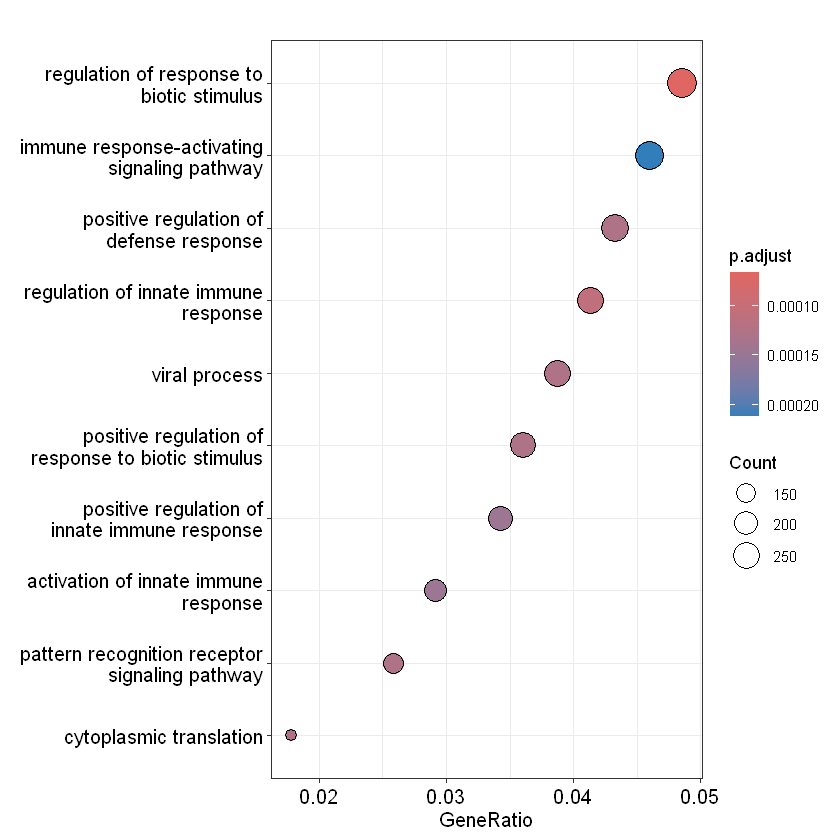

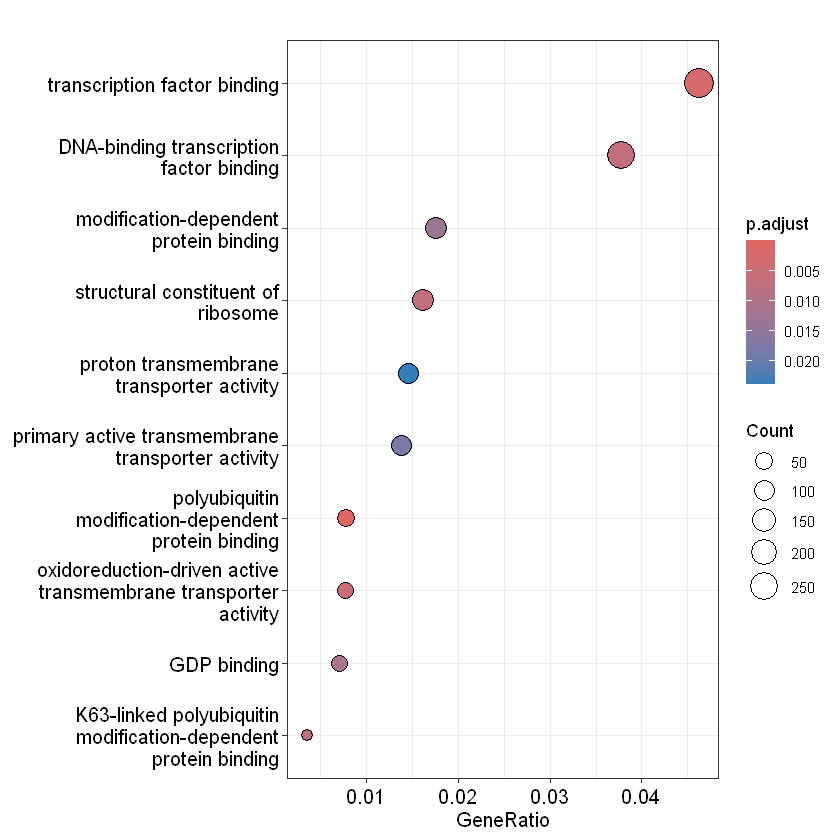

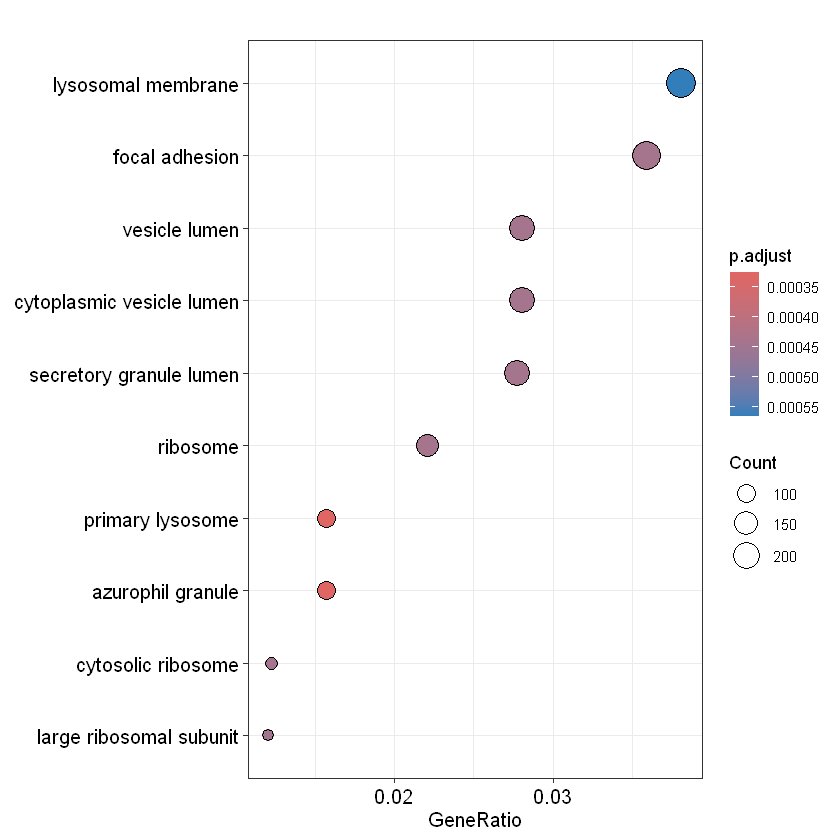

In [71]:
universe_genes.v <- res.lfcShrink.tbl_df %>%
  filter(!is.na(padj)) %>% # here we preserve any gene that does not have missing data after independent filtering in the results object
  pull(feature_id)

length(universe_genes.v)

bp.enrichResult <- enrichGO(gene = significant_genes.v, # specifify the significant set of genes
         OrgDb = org.Hs.eg.db,
         keyType = "ENSEMBL",
         ont = "BP", # select Biological Process ontology. Molecular Function (MF) and Cellular Compartment (CC) may also be interesting
         pAdjustMethod = "BH",
         universe = universe_genes.v) # specify the background set of genes
dotplot(bp.enrichResult, showCategory=10)
mf.enrichResult <- enrichGO(gene = significant_genes.v, # specifify the significant set of genes
         OrgDb = org.Hs.eg.db,
         keyType = "ENSEMBL",
         ont = "MF", # select Biological Process ontology. Molecular Function (MF) and Cellular Compartment (CC) may also be interesting
         pAdjustMethod = "BH",
         universe = universe_genes.v) # specify the background set of genes
dotplot(mf.enrichResult, showCategory=10)
cc.enrichResult <- enrichGO(gene = significant_genes.v, # specifify the significant set of genes
         OrgDb = org.Hs.eg.db,
         keyType = "ENSEMBL",
         ont = "CC", # select Biological Process ontology. Molecular Function (MF) and Cellular Compartment (CC) may also be interesting
         pAdjustMethod = "BH",
         universe = universe_genes.v) # specify the background set of genes
dotplot(cc.enrichResult, showCategory=10)

#### Hypertensive and Resistant Hypertension

In [96]:
dds$condition <- relevel(dds$condition, ref = "Hypertension")

In [97]:
dds <- DESeq(dds)

using pre-existing normalization factors

estimating dispersions

found already estimated dispersions, replacing these

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

final dispersion estimates

fitting model and testing

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

-- replacing outliers and refitting for 166 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating di

In [98]:
res_EH_RH <- results(dds, contrast = c('condition','Resistant Hypertension','Hypertension'),alpha = 0.05)

# View
res_EH_RH

log2 fold change (MLE): condition Resistant Hypertension vs Hypertension 
Wald test p-value: condition Resistant.Hypertension vs Hypertension 
DataFrame with 22749 rows and 6 columns
                  baseMean log2FoldChange     lfcSE      stat    pvalue
                 <numeric>      <numeric> <numeric> <numeric> <numeric>
ENSG00000000003    1.89727       1.755207  1.103304   1.59086 0.1116401
ENSG00000000419   87.83449       0.349809  0.208788   1.67542 0.0938512
ENSG00000000457   77.26543       0.365557  0.218282   1.67470 0.0939935
ENSG00000000460   18.68055      -0.602646  0.405182  -1.48735 0.1369232
ENSG00000000938 4575.90143      -0.226860  0.131597  -1.72390 0.0847264
...                    ...            ...       ...       ...       ...
ENSG00000293550  35.118450      -0.880603  0.362966 -2.426132 0.0152607
ENSG00000293552   0.657624       0.948354  2.071140  0.457890 0.6470315
ENSG00000293553   0.652694      -2.669939  2.295173 -1.163285 0.2447140
ENSG00000293555   0.26045

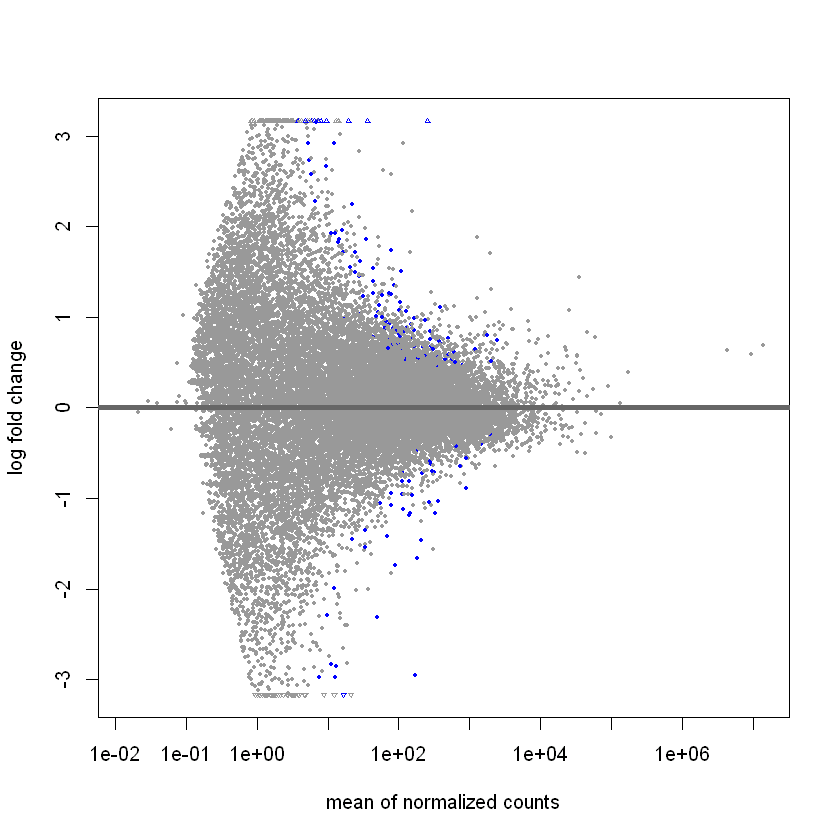

In [99]:
plotMA(res_EH_RH)

In [100]:
resultsNames(dds) # Here we can see the coefficients including 'condition_tumor_vs_normal'

# note: by providing res as an argument we ensure that alpha = 0.05 is also the basis for p-values reported by lfcShrink.
res.lfcShrink <- lfcShrink(dds, 
                           res = res_EH_RH,
                           coef = 'condition_Resistant.Hypertension_vs_Hypertension',
                           type = 'ashr')
# View
res.lfcShrink

[1] "Intercept"                                       
[2] "condition_Normal_vs_Hypertension"                
[3] "condition_Resistant.Hypertension_vs_Hypertension"

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041



log2 fold change (MMSE): condition Resistant Hypertension vs Hypertension 
Wald test p-value: condition Resistant.Hypertension vs Hypertension 
DataFrame with 22749 rows and 5 columns
                  baseMean log2FoldChange     lfcSE    pvalue      padj
                 <numeric>      <numeric> <numeric> <numeric> <numeric>
ENSG00000000003    1.89727      0.0650378  0.228690 0.1116401        NA
ENSG00000000419   87.83449      0.1653572  0.146206 0.0938512  0.449466
ENSG00000000457   77.26543      0.1650650  0.149617 0.0939935  0.449914
ENSG00000000460   18.68055     -0.1207284  0.187541 0.1369232  0.517676
ENSG00000000938 4575.90143     -0.1555685  0.109715 0.0847264  0.436043
...                    ...            ...       ...       ...       ...
ENSG00000293550  35.118450    -0.22330169  0.209995 0.0152607   0.23141
ENSG00000293552   0.657624     0.01035522  0.217205 0.6470315        NA
ENSG00000293553   0.652694    -0.02450330  0.225350 0.2447140        NA
ENSG00000293555   0.2604

In [101]:
summary(res.lfcShrink)
sum(is.na(res.lfcShrink$log2FoldChange))


out of 22737 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 115, 0.51%
LFC < 0 (down)     : 45, 0.2%
outliers [1]       : 0, 0%
low counts [2]     : 6624, 29%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



[1] 0

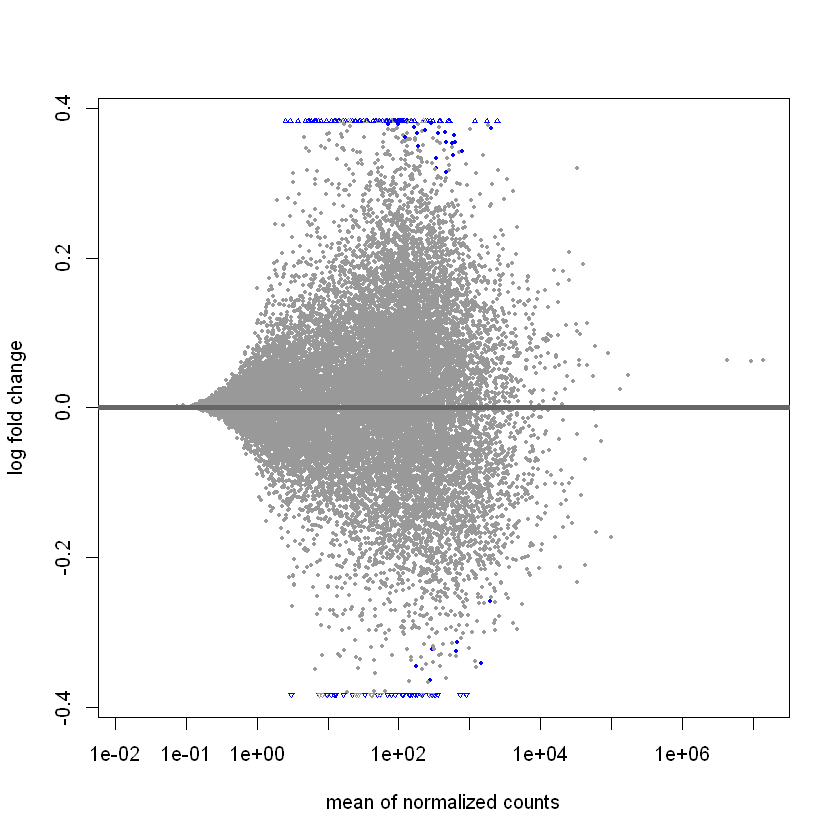

In [102]:
plotMA(res.lfcShrink)

Much fewer differentially expressed genes in this comparison, which is expected since these two disease types are very similar

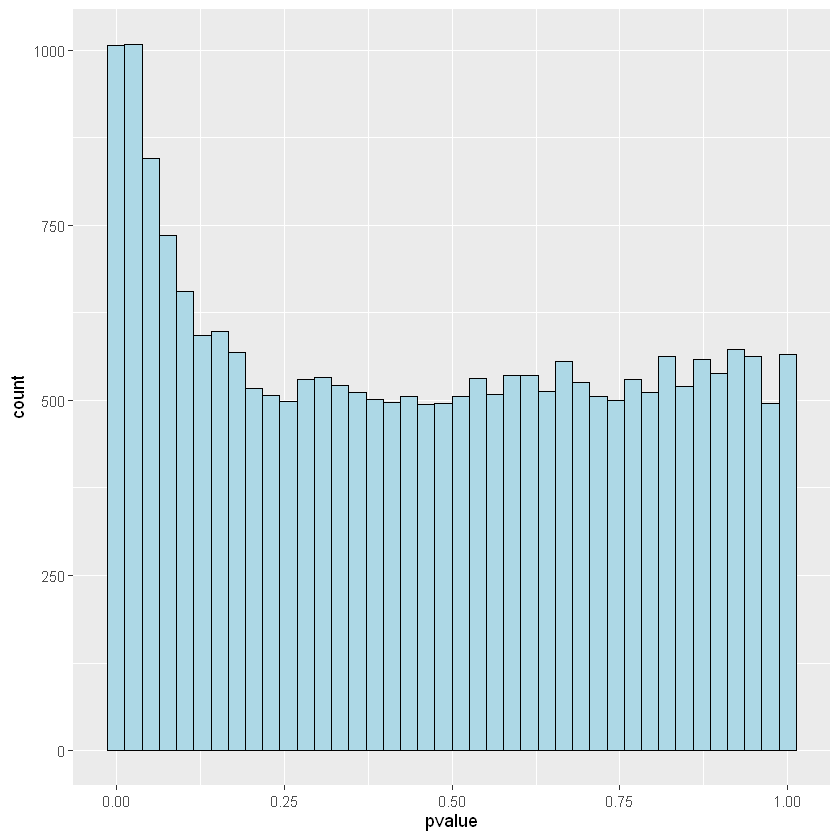

In [103]:
res.lfcShrink %>%
  as_tibble() %>% # coerce to tibble
  ggplot(aes(pvalue)) + 
  geom_histogram(fill="light blue",color='black',bins = 40)

As expected see a uniform distribution in counts for most p-values however there is a slight increase of counts

In [104]:
res.lfcShrink.tbl_df <- res.lfcShrink %>%
  as.data.frame() %>%
  rownames_to_column(var = "feature_id") %>%
  as_tibble()

res.lfcShrink.tbl_df %>% 
  arrange(padj) # sort tibble in ascending order on adjusted p-value (FDR)

feature_id,baseMean,log2FoldChange,lfcSE,pvalue,padj
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000285238,16.635632,-22.7614141,3.2639550,1.135212e-12,1.830529e-08
ENSG00000092020,103.916864,1.0388796,0.2405630,1.715375e-09,1.383021e-05
ENSG00000288859,7.442256,20.2808649,3.6382145,3.232299e-09,1.737361e-05
ENSG00000128789,120.374620,0.6474752,0.1743121,2.610307e-08,1.052280e-04
ENSG00000163584,28.880280,1.3487637,0.4150425,3.455002e-07,1.114238e-03
ENSG00000171202,20.980487,1.2688969,0.4115155,4.479148e-07,1.203771e-03
ENSG00000186300,22.430566,1.7787875,0.6090770,9.348812e-07,2.153566e-03
ENSG00000205903,739.557631,-0.4771424,0.1285693,1.117674e-06,2.252812e-03
ENSG00000235288,5.753552,2.7238481,1.5962549,1.412572e-06,2.530859e-03


Warning message:
"Removed 6624 rows containing missing values or values outside the scale range
(`geom_point()`)."


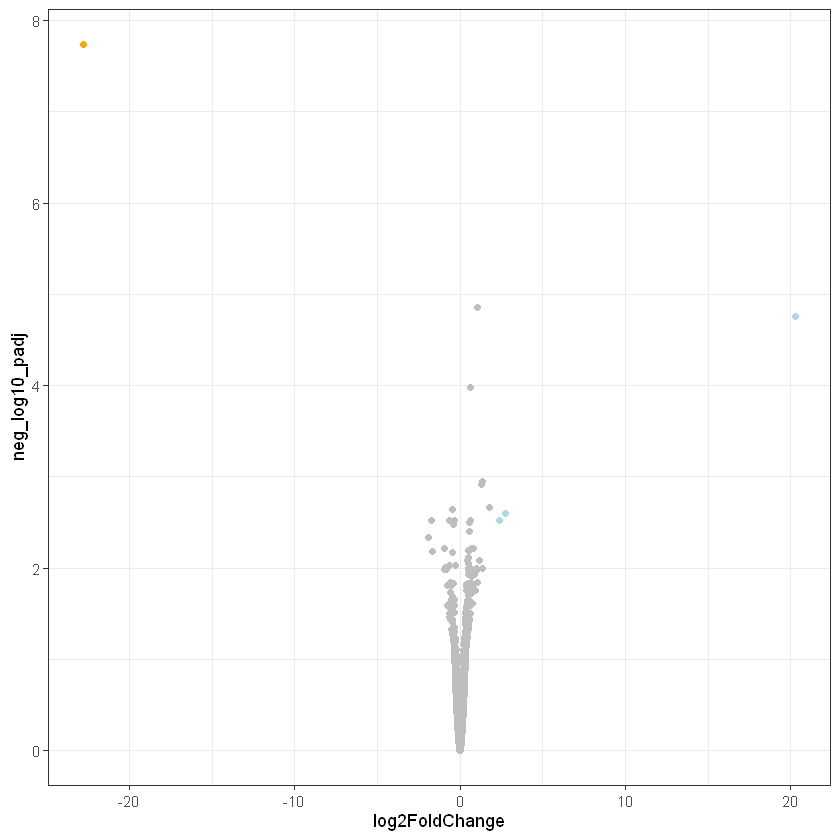

In [107]:
res.lfcShrink.tbl_df %>% # pipe the data.frame (tibble) to mutate to add a column named "neg_log10_padj" with negative log10 adjusted p-values
  mutate(neg_log10_padj = -1*log10(padj)) %>% # pipe the modified data.frame (tibble) to first (data) argument of ggplot
  ggplot(aes(x = log2FoldChange, y = neg_log10_padj)) + # define which columns (variables) to plot on x and y axes with aes()
  geom_point(color = 'gray') + # add gray points
  geom_point( data = ~.x %>% filter(log2FoldChange < -2 & neg_log10_padj > 2), color = 'orange') + # add a second layer of orange points on subset of data
  geom_point( data = ~.x %>% filter(log2FoldChange > 2 & neg_log10_padj > 2), color = 'light blue') + # add a third layer of blue points on subset of data
  theme_bw()

Very little of differentially expressed genes, soley just upregulated. Again see an upregulated and downregulated gene with a log fold 2 change of over 20

In [108]:
significant_genes.v <- res.lfcShrink.tbl_df %>%
  filter(!is.na(padj)) %>% # retain only genes that don't have NA in padj column
  filter(padj < 0.05) %>% # retain only genes with FDR < 0.05
  pull(feature_id)

In [109]:
ensembl2gene.tbl_df <- AnnotationDbi::select(org.Hs.eg.db, keys=significant_genes.v, 
                  columns="SYMBOL", keytype="ENSEMBL") %>%
            as_tibble()
ensembl2gene.tbl_df

'select()' returned 1:many mapping between keys and columns



ENSEMBL,SYMBOL
<chr>,<chr>
ENSG00000005206,SPPL2B
ENSG00000008018,PSMB1
ENSG00000009844,VTA1
ENSG00000010322,NISCH
ENSG00000011260,UTP18
ENSG00000011376,LARS2
ENSG00000022567,SLC45A4
ENSG00000026652,AGPAT4
ENSG00000038274,MAT2B


In [84]:
res.lfcShrink.tbl_df<- inner_join(x = res.lfcShrink.tbl_df, # DESeq2 results tibble
           y = ensembl2gene.tbl_df, # ENSEMBL to gene symbol map tibble
           by = join_by(feature_id == ENSEMBL) ) %>%
            arrange(padj) 

In [110]:
significant_genes_EH_RH <- inner_join(x = res.lfcShrink.tbl_df, # DESeq2 results tibble
           y = ensembl2gene.tbl_df, # ENSEMBL to gene symbol map tibble
           by = join_by(feature_id == ENSEMBL) ) %>%
            arrange(padj)


In [111]:
write.csv(significant_genes_EH_RH,"sig_genes_hypertensive_vs_resistive.csv",row.names=FALSE)

In [112]:
significant_genes_EH_RH

feature_id,baseMean,log2FoldChange,lfcSE,pvalue,padj,SYMBOL
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ENSG00000285238,16.635632,-22.7614141,3.2639550,1.135212e-12,1.830529e-08,NA
ENSG00000092020,103.916864,1.0388796,0.2405630,1.715375e-09,1.383021e-05,PPP2R3C
ENSG00000288859,7.442256,20.2808649,3.6382145,3.232299e-09,1.737361e-05,H2AC19
ENSG00000128789,120.374620,0.6474752,0.1743121,2.610307e-08,1.052280e-04,PSMG2
ENSG00000163584,28.880280,1.3487637,0.4150425,3.455002e-07,1.114238e-03,RPL22L1
ENSG00000171202,20.980487,1.2688969,0.4115155,4.479148e-07,1.203771e-03,TMEM126A
ENSG00000186300,22.430566,1.7787875,0.6090770,9.348812e-07,2.153566e-03,ZNF555
ENSG00000205903,739.557631,-0.4771424,0.1285693,1.117674e-06,2.252812e-03,ZNF316
ENSG00000235288,5.753552,2.7238481,1.5962549,1.412572e-06,2.530859e-03,NA


In [87]:
universe_genes.v <- res.lfcShrink.tbl_df %>%
  filter(!is.na(padj)) %>% # here we preserve any gene that does not have missing data after independent filtering in the results object
  pull(feature_id)

length(universe_genes.v)

bp.enrichResult <- enrichGO(gene = significant_genes.v, # specifify the significant set of genes
         OrgDb = org.Hs.eg.db,
         keyType = "ENSEMBL",
         ont = "BP", # select Biological Process ontology. Molecular Function (MF) and Cellular Compartment (CC) may also be interesting
         pAdjustMethod = "BH",
         universe = universe_genes.v) # specify the background set of genes
dotplot(bp.enrichResult, showCategory=10)
mf.enrichResult <- enrichGO(gene = significant_genes.v, # specifify the significant set of genes
         OrgDb = org.Hs.eg.db,
         keyType = "ENSEMBL",
         ont = "MF", # select Biological Process ontology. Molecular Function (MF) and Cellular Compartment (CC) may also be interesting
         pAdjustMethod = "BH",
         universe = universe_genes.v) # specify the background set of genes
dotplot(mf.enrichResult, showCategory=10)
cc.enrichResult <- enrichGO(gene = significant_genes.v, # specifify the significant set of genes
         OrgDb = org.Hs.eg.db,
         keyType = "ENSEMBL",
         ont = "CC", # select Biological Process ontology. Molecular Function (MF) and Cellular Compartment (CC) may also be interesting
         pAdjustMethod = "BH",
         universe = universe_genes.v) # specify the background set of genes
dotplot(cc.enrichResult, showCategory=10)

[1] 161

Warning message in rep(yes, length.out = len):
"'x' is NULL so the result will be NULL"
ERROR while rich displaying an object: Error in ans[ypos] <- rep(yes, length.out = len)[ypos]: replacement has length zero

Traceback:
1. sapply(x, f, simplify = simplify)
2. lapply(X = X, FUN = FUN, ...)
3. FUN(X[[i]], ...)
4. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
5. tryCatchList(expr, classes, parentenv, handlers)
6. tryCatchOne(expr, names, parentenv, handlers[[1L]])
7. doTryCatch(return(expr), name, parentenv, handler)
8. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)

Interestingly the biological processes that the significant genes are related to have to do with transmembrane transport. This could be the possible link to HCLZ since KCLZ specifically targets calcium transporters.

## Significant genes Comparisons

In [88]:
# Differential signigicant genes found between Normal and Hypertensive
sig_genes_N_EH

feature_id,baseMean,log2FoldChange,lfcSE,pvalue,padj,SYMBOL
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ENSG00000133317,124.1244,2.521671,0.2025303,1.035015e-37,1.988265e-33,LGALS12
ENSG00000092020,103.9169,-2.059018,0.1796573,1.152946e-31,1.107405e-27,PPP2R3C
ENSG00000110852,215.6333,-2.325658,0.2094339,2.281778e-30,1.461099e-26,CLEC2B
ENSG00000108828,421.3082,1.822094,0.1635725,9.179701e-30,4.408552e-26,VAT1
ENSG00000067225,4882.3588,1.436431,0.1293142,3.145952e-29,1.208675e-25,PKM
ENSG00000101439,7686.4031,2.187182,0.2020893,9.147719e-29,2.692844e-25,CST3
ENSG00000204619,649.9800,1.183894,0.1071916,9.812548e-29,2.692844e-25,PPP1R11
ENSG00000117984,10217.1380,2.179612,0.2078498,3.461684e-27,8.312369e-24,CTSD
ENSG00000198816,166.7187,2.440578,0.2357146,4.243005e-27,9.056459e-24,ZNF358


In [89]:
# Want to observe the gene that is showing 20 fold negativve FC
sig_genes_N_EH %>% arrange(log2FoldChange, decreasing = TRUE)

feature_id,baseMean,log2FoldChange,lfcSE,pvalue,padj,SYMBOL
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ENSG00000275895,2.744529,-19.340235,4.2027708,6.458198e-09,7.783060e-08,LOC102724594
ENSG00000259070,7.329530,-3.276523,0.7893878,2.466233e-10,4.275843e-09,LINC00639
ENSG00000266923,6.391474,-3.231764,0.8041789,5.070809e-10,8.023907e-09,NA
ENSG00000205809,11.712601,-3.069238,0.7310319,9.029906e-10,1.331309e-08,KLRC2
ENSG00000114107,5.555396,-2.588384,0.6393225,4.076662e-08,4.022223e-07,CEP70
ENSG00000176731,34.946245,-2.569981,0.3494575,7.278111e-16,6.472801e-14,RBIS
ENSG00000113356,2.547300,-2.433362,0.6995756,5.398777e-07,3.981209e-06,POLR3G
ENSG00000106526,4.514295,-2.398331,0.7313734,9.912951e-07,6.909571e-06,ACTR3C
ENSG00000197808,14.579892,-2.384838,0.4100215,4.740469e-11,9.898305e-10,ZNF461


In the hypertensive group the gene LOC102724594 is shown to be downregulated by 20 fold from the normal group.

In [90]:
# Differential signigicant genes found between Normal and Resistant Hypertensive
sig_genes_N_RH

feature_id,baseMean,log2FoldChange,lfcSE,pvalue,padj,SYMBOL
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ENSG00000275895,2.744529,-20.111520,3.7919873,3.592153e-09,6.591308e-08,LOC102724594
ENSG00000285238,16.635632,-5.618851,6.6669739,3.600406e-06,2.975504e-05,NA
ENSG00000144290,26.645763,-2.512499,0.5968510,1.447827e-08,2.322807e-07,SLC4A10
ENSG00000104290,18.771429,-2.404233,0.7923185,2.266819e-06,1.984021e-05,FZD3
ENSG00000009694,20.825482,-2.010194,0.5178198,2.434321e-07,2.816194e-06,TENM1
ENSG00000169429,71.713461,-1.966828,0.5010139,2.457585e-07,2.837317e-06,CXCL8
ENSG00000134545,21.482369,-1.938691,0.5763321,2.619295e-06,2.238379e-05,KLRC1
ENSG00000030419,85.357044,-1.905978,0.3534479,2.504985e-10,6.191829e-09,IKZF2
ENSG00000234678,5.867037,-1.901907,0.8281641,8.383260e-05,4.651410e-04,NA


Again LOC102724594 is down regulated in the resistant hypertension which is a possible gene that causes the difference between a normal and hypertensive phenotype. Furthermore In the resistant hypertension the gene H2AC19 is upregulated than the normal.

In [91]:
sig_genes_N_EH %>% filter(SYMBOL=="H2AC19") # This gene not observed as differentially expressed in hypertensive group

feature_id,baseMean,log2FoldChange,lfcSE,pvalue,padj,SYMBOL
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>


In [92]:
# Differential significant genes found between Hypertensive and Resistant Hypertensive
significant_genes_EH_RH %>% arrange(log2FoldChange)

feature_id,baseMean,log2FoldChange,lfcSE,pvalue,padj,SYMBOL.x,SYMBOL.y
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
ENSG00000285238,16.635632,-22.7614141,3.2639550,1.135212e-12,1.830529e-08,NA,NA
ENSG00000225630,168.913809,-1.8894481,1.0142609,5.140387e-06,4.604930e-03,MTND2P28,MTND2P28
ENSG00000135862,50.455451,-1.7051773,0.7147684,2.604379e-06,3.024373e-03,LAMC1,LAMC1
ENSG00000105737,12.897691,-1.6811622,1.0928986,1.013962e-05,6.540056e-03,GRIK5,GRIK5
ENSG00000071242,69.645263,-0.9386861,0.4741321,7.581521e-06,6.112601e-03,RPS6KA2,RPS6KA2
ENSG00000161905,181.040032,-0.9380262,0.6037993,2.629839e-05,1.034296e-02,ALOX15,ALOX15
ENSG00000267278,22.441904,-0.8546123,0.5060580,2.017511e-05,9.858291e-03,NA,NA
ENSG00000075240,205.400497,-0.8184958,0.5108102,2.774833e-05,1.037173e-02,GRAMD4,GRAMD4
ENSG00000290427,33.331284,-0.7610925,0.5447886,5.604512e-05,1.558151e-02,NA,NA


In [409]:
significant_genes_EH_RH %>% filter(SYMBOL=="LOC102724594")

feature_id,baseMean,log2FoldChange,lfcSE,pvalue,padj,SYMBOL
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>


In [94]:
significant_genes_EH_RH

feature_id,baseMean,log2FoldChange,lfcSE,pvalue,padj,SYMBOL.x,SYMBOL.y
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
ENSG00000285238,16.635632,-22.7614141,3.2639550,1.135212e-12,1.830529e-08,NA,NA
ENSG00000092020,103.916864,1.0388796,0.2405630,1.715375e-09,1.383021e-05,PPP2R3C,PPP2R3C
ENSG00000288859,7.442256,20.2808649,3.6382145,3.232299e-09,1.737361e-05,H2AC19,H2AC19
ENSG00000128789,120.374620,0.6474752,0.1743121,2.610307e-08,1.052280e-04,PSMG2,PSMG2
ENSG00000163584,28.880280,1.3487637,0.4150425,3.455002e-07,1.114238e-03,RPL22L1,RPL22L1
ENSG00000171202,20.980487,1.2688969,0.4115155,4.479148e-07,1.203771e-03,TMEM126A,TMEM126A
ENSG00000186300,22.430566,1.7787875,0.6090770,9.348812e-07,2.153566e-03,ZNF555,ZNF555
ENSG00000205903,739.557631,-0.4771424,0.1285693,1.117674e-06,2.252812e-03,ZNF316,ZNF316
ENSG00000235288,5.753552,2.7238481,1.5962549,1.412572e-06,2.530859e-03,NA,NA


Interestingly we see H2AC19 is upregulated in the resistant hypertensive group making this a gene that adds to the difference between resistant and hypertensive. THere is also a down regulation in the Resistant Hypertensive group which is found to be a novel transcript. Interestingly this expression is downregulated compared to the normal but at a lower magnitude. Gene LOC102724594 is a similarly expressed gene in the disease type.

In [113]:
sig_genes <- rbind(significant_genes_EH_RH,sig_genes_N_EH,sig_genes_N_RH)

In [114]:
dim(sig_genes)

[1] 15954     7

In [116]:
normalizedvalue <- counts(dds,normalized=TRUE)
normvalue_wname <- normalizedvalue
normvalue_wname <- as.data.frame(normvalue_wname)
normvalue_wname$gene <- rownames(normalizedvalue)
# norm_melt <- melt(normvalue_wname)

In [117]:
interaction_all_normvalues = normalizedvalue[sig_genes$feature_id,]

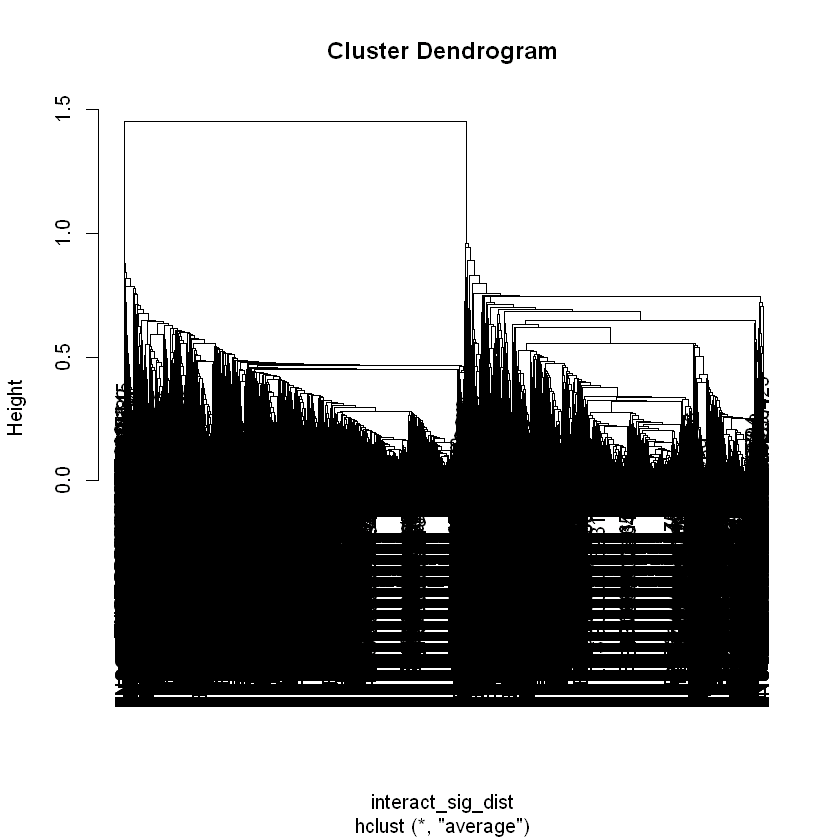

In [118]:
interact_sig_dist = as.dist(1 - cor(t(interaction_all_normvalues)))
interact_sig_hclust = hclust(interact_sig_dist,
                             method="average")
plot(interact_sig_hclust)

In [120]:
library("pheatmap")

In [127]:
metadata.df <- metadata.df %>% select(condition)
metadata.df

,condition
,<fct>
RH_01,Resistant Hypertension
RH_02,Resistant Hypertension
RH_03,Resistant Hypertension
RH_04,Resistant Hypertension
RH_05,Resistant Hypertension
RH_06,Resistant Hypertension
RH_07,Resistant Hypertension
RH_08,Resistant Hypertension
RH_09,Resistant Hypertension


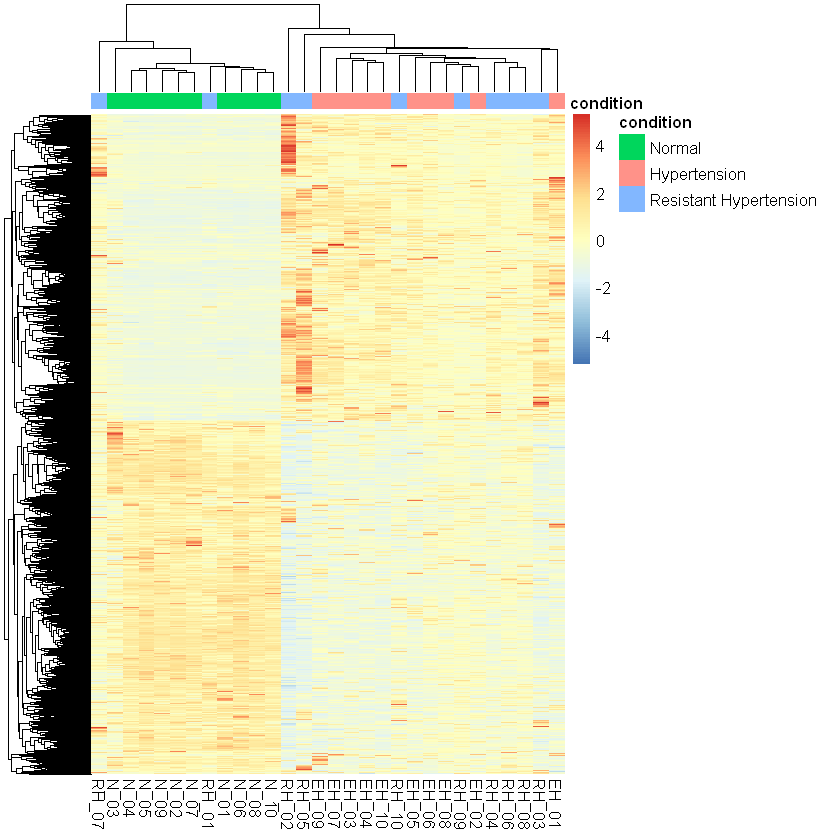

In [128]:
pheatmap(interaction_all_normvalues,annotation_col = metadata.df,
         scale="row",cluster_cols = T, show_rownames = F)

### Drug-Genome Interaction

# NEXT STEPS

### Gather the top differntially genes in each group determine similarities and differences. Determine the genes that are producing 20 fold differences. Using the top gene drug interactions between HCLZ and hypertension and determine if these are in fact represented as differences in this study particularly between the resistant hypertensive group and hypertension group. Use go annotations to determine the significance of these genes.

### With the significant genes found use dgIB to annotate and see if there could be new potential specific gene targets.

In [424]:
PC1 <- top_gene_names_PC1 %>% as.data.frame() #%>% pivot_longer()
PC2 <- top_gene_names_PC2 %>% as.data.frame()

In [425]:
colnames(PC2)

[1] "ENSG00000076864" "ENSG00000167768" "ENSG00000285245" "ENSG00000250361"
 [5] "ENSG00000133742" "ENSG00000158578" "ENSG00000223609" "ENSG00000004939"
 [9] "ENSG00000174358" "ENSG00000143416"

In [445]:
PC1_genes <- PC1 %>% pivot_longer(cols = colnames(PC1), names_to = "ENSEMBLE",values_to = "PC1") %>% pull(ENSEMBLE)

In [444]:
PC2_genes <- PC2 %>% pivot_longer(cols = colnames(PC2), names_to = "ENSEMBLE",values_to = "PC2") %>% pull(ENSEMBLE)

In [423]:
PC1_genes_df <- AnnotationDbi::select(org.Hs.eg.db, keys=PC1_genes, 
                  columns="SYMBOL", keytype="ENSEMBL") %>%
            as_tibble()
PC1_genes_df

'select()' returned 1:1 mapping between keys and columns



ENSEMBL,SYMBOL
<chr>,<chr>
ENSG00000162366,PDZK1IP1
ENSG00000178297,TMPRSS9
ENSG00000013306,SLC25A39
ENSG00000206177,HBM
ENSG00000086506,HBQ1
ENSG00000244734,HBB
ENSG00000143774,GUK1
ENSG00000187017,ESPN
ENSG00000269711,NA


In [432]:
PC2_genes_df <- AnnotationDbi::select(org.Hs.eg.db, keys=PC2_genes, 
                  columns="SYMBOL", keytype="ENSEMBL") %>%
            as_tibble()
PC2_genes_df

'select()' returned 1:1 mapping between keys and columns



ENSEMBL,SYMBOL
<chr>,<chr>
ENSG00000076864,RAP1GAP
ENSG00000167768,KRT1
ENSG00000285245,NA
ENSG00000250361,GYPB
ENSG00000133742,CA1
ENSG00000158578,ALAS2
ENSG00000223609,HBD
ENSG00000004939,SLC4A1
ENSG00000174358,SLC6A19


In [430]:
sig_genes_N_RH %>% filter(SYMBOL == "PDZK1IP1")

feature_id,baseMean,log2FoldChange,lfcSE,pvalue,padj,SYMBOL
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ENSG00000162366,3696.526,3.930874,0.5762411,2.812903e-14,2.224941e-12,PDZK1IP1


In [446]:
loadings['ENSG00000000003',]

PC1           PC2           PC3           PC4           PC5 
-2.420557e-03 -7.183512e-03  5.361868e-03 -2.118285e-03  5.017367e-03 
          PC6           PC7           PC8           PC9          PC10 
-1.085873e-04  4.124571e-03 -1.553685e-03 -5.051175e-03 -1.039247e-04 
         PC11          PC12          PC13          PC14          PC15 
-1.014258e-05 -9.629013e-04 -2.137166e-03 -2.203572e-03 -2.243021e-04 
         PC16          PC17          PC18          PC19          PC20 
-2.660629e-03 -5.572871e-04  8.470356e-03 -7.448738e-03 -6.210220e-03 
         PC21          PC22          PC23          PC24          PC25 
 5.814419e-03 -4.728378e-03 -8.885460e-03  1.858603e-03  3.197252e-03 
         PC26          PC27          PC28          PC29          PC30 
-1.344125e-02 -9.368525e-04  3.460800e-04 -2.224286e-03 -9.724082e-02

In [439]:
loadings["ENSG00000275895",] %>% as.data.frame()

,.
,<dbl>
PC1,-0.0016116008
PC2,0.0145286206
PC3,0.0058303347
PC4,-0.0005991997
PC5,0.0251572954
PC6,0.0226843541
PC7,-0.0225876660
PC8,0.0166304495
PC9,0.0125638847


In [451]:
dgib <- list('YEATS4','FBXL17','NUCB2','DIAPH3','ILKAP','PLCE1','UGGT2','LUC7L2','TTC6','VASP','NELL1','ADO','BEST3','ANKFN1') %>% unlist()
dgib

[1] "YEATS4" "FBXL17" "NUCB2"  "DIAPH3" "ILKAP"  "PLCE1"  "UGGT2"  "LUC7L2"
 [9] "TTC6"   "VASP"   "NELL1"  "ADO"    "BEST3"  "ANKFN1"

In [468]:
dgib_EH_RH <- significant_genes_EH_RH[significant_genes_EH_RH$SYMBOL %in% dgib, ]
dgib_EH_RH

feature_id,baseMean,log2FoldChange,lfcSE,pvalue,padj,SYMBOL
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>


Highly correlated genes show no differential expression between hypertensive and resistant hypertension groups

In [467]:
significant_genes_EH_RH %>% filter(SYMBOL == "ANKFN1")

feature_id,baseMean,log2FoldChange,lfcSE,pvalue,padj,SYMBOL
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>


In [469]:
dgib_N_EH <- sig_genes_N_EH[sig_genes_N_EH$SYMBOL %in% dgib, ]
dgib_N_EH

feature_id,baseMean,log2FoldChange,lfcSE,pvalue,padj,SYMBOL
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ENSG00000146963,278.179881,-0.8367215,0.1482875,1.076455e-08,1.238245e-07,LUC7L2
ENSG00000138193,5.203784,-1.6024322,0.5281340,2.097698e-04,8.245709e-04,PLCE1
ENSG00000125753,5520.685638,0.6733130,0.1931078,3.611781e-04,1.334789e-03,VASP
ENSG00000102595,3.939647,-1.2672532,0.5567672,4.297681e-03,1.193075e-02,UGGT2
ENSG00000181915,93.597688,-0.6143235,0.2379432,7.505345e-03,1.951512e-02,ADO
ENSG00000145743,84.077023,-0.7851758,0.3293094,1.061794e-02,2.633849e-02,FBXL17
ENSG00000070081,88.230043,-0.6548174,0.2715501,1.157514e-02,2.842731e-02,NUCB2


In [470]:
dgib_N_RH <- sig_genes_N_RH[sig_genes_N_RH$SYMBOL %in% dgib, ]
dgib_N_RH

feature_id,baseMean,log2FoldChange,lfcSE,pvalue,padj,SYMBOL
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ENSG00000127337,22.94487,-1.0616294,0.3693361,8.766294e-04,0.0035318549,YEATS4
ENSG00000145743,84.07702,-1.0166652,0.3263382,4.945261e-04,0.0021742271,FBXL17
ENSG00000070081,88.23004,-0.9965283,0.2729939,8.141957e-05,0.0004551680,NUCB2
ENSG00000146963,278.17988,-0.6618073,0.1490702,5.779722e-06,0.0000455046,LUC7L2
ENSG00000125753,5520.68564,0.4335302,0.1910142,1.878412e-02,0.0456216456,VASP


In [489]:
res.lfcShrink.tbl_df %>% filter(feature_id == 'ENSG00000127337')

feature_id,baseMean,log2FoldChange,lfcSE,pvalue,padj
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000127337,22.94487,-0.09113801,0.187575,0.2337518,0.633497
